<a href="https://colab.research.google.com/github/kaitken17/colab_stuff/blob/master/mnist_analysis_multiclass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow_text

     |████████████████████████████████| 2.6MB 8.0MB/s 


In [2]:
import functools

import jax
import jax.numpy as jnp
from jax.experimental import optimizers, stax

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds

from tqdm.notebook import tqdm

import os
import time
import pickle

from sklearn.decomposition import PCA

import sys
sys.path.append('/content/drive/My Drive/ml_research/fixedpoints_nlp/reverse-engineering-neural-networks')

import renn

In [3]:
# Skips any tests and just runs function definitions
run_tests = False

# Load In Data

#### PyTorch

In [4]:
import torch
import torchvision
from torchvision import transforms, datasets

train_data = datasets.MNIST('', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
test_data = datasets.MNIST('', train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))

Extracting MNIST/raw/train-images-idx3-ubyte.gz to MNIST/raw


Extracting MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/raw


Extracting MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/raw


Extracting MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [45]:
def convert_serialized_mnist(train_data, test_data, smnist_params, train_params):
  """
  Prunes classes in MNIST and converts into serialized data
  """

  mnist_classes = smnist_params['mnist_classes']
  n_classes = len(mnist_classes)
  n_len = smnist_params['n_len']
  n_inputs = smnist_params['n_inputs']
  time_dim = smnist_params['time_dim']
  batch_size = train_params['batch_size']

  # Prunes classes that are not in 'mnist_classes'
  target_bools = np.zeros((n_classes, len(train_data.targets)))
  for digit_idx in range(len(mnist_classes)):
    target_bools[digit_idx] = train_data.targets==mnist_classes[digit_idx]

  idx = []
  for mnist_idx in range(len(train_data.targets)):
    if target_bools[:, mnist_idx].any(): idx.append(mnist_idx)

  train_data_subset = torch.utils.data.Subset(train_data, idx)
  trainset = torch.utils.data.DataLoader(train_data_subset, batch_size=batch_size, shuffle=True)

  test_bools = np.zeros((n_classes, len(test_data.targets)))
  for digit_idx in range(len(mnist_classes)):
    test_bools[digit_idx] = test_data.targets==mnist_classes[digit_idx]

  idx = []
  for mnist_idx in range(len(test_data.targets)):
    if test_bools[:, mnist_idx].any(): idx.append(mnist_idx)

  test_data_subset = torch.utils.data.Subset(test_data, idx)
  testset = torch.utils.data.DataLoader(test_data_subset, batch_size=batch_size, shuffle=True)

  def convert_to_jax(dataset):
    """ Converts dataset into JAX """
    images_np = np.zeros((len(dataset)-1, batch_size, n_len, n_inputs)) # batch number x batch_index x n_len x n_inputs
    labels_np = np.zeros((len(dataset)-1, batch_size, n_len, n_classes)) # batch number x batch_index x one-hot-vector
    masks_np = np.zeros((len(dataset)-1, batch_size, 1))
    counter = 0
    for train_vals, idx in zip(dataset, range(len(dataset))):
      images, labels = train_vals[0], train_vals[1]
      squeezed_images = np.squeeze(images.numpy())
      if squeezed_images.shape[0] == batch_size: 
        batch_images = np.squeeze(images.numpy())
        if time_dim == 'Rows':
          images_np[idx] = batch_images
        elif time_dim == 'Columns':
          images_np[idx] = np.swapaxes(batch_images, 1, 2)
        masks_np[idx, :] = (n_len-1) * np.ones((batch_size, 1))
        for label, lbl_idx in zip(labels, range(len(labels))):
          one_hot = np.zeros((n_classes,))
          one_hot[mnist_classes.index(label)] = 1
          labels_np[idx, lbl_idx, n_len-1] = one_hot
      else:
        print('Omitting incomplete batch')

    jax_data = {
      'inputs': jnp.asarray(images_np),  # batch number x batch_index x n_len x n_inputs
      'labels': jnp.asarray(labels_np), # batch number x batch_index x n_len x one-hot-vector
      'index': jnp.asarray(masks_np, dtype=jnp.int32), # Target mask: list of integers up to phrase_len
    }
    
    return jax_data

  train_jax = convert_to_jax(trainset)
  test_jax = convert_to_jax(testset)

  return train_jax, test_jax

run_tests = True
if run_tests:
  smnist_params = {
    'mnist_classes': [3, 4, 7],
    'n_len' : 28,
    'time_dim': 'Columns'
  }
  smnist_params['n_inputs'] = int(28*28/smnist_params['n_len'])

  train_params = {'batch_size': 128}
    
  train_jax, test_jax = convert_serialized_mnist(train_data, test_data, smnist_params, train_params)

Omitting incomplete batch
Omitting incomplete batch


[1. 0. 0.]


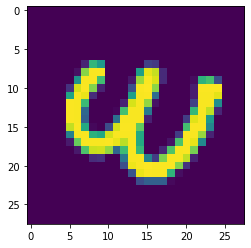

First few inputs


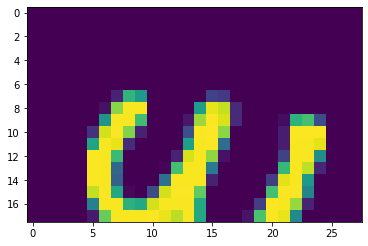

[0. 1. 0.]


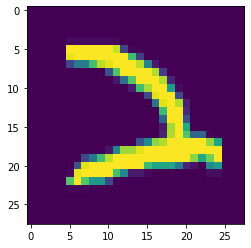

[1. 0. 0.]


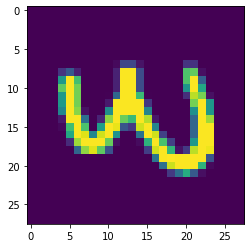

In [46]:
print(np.asarray(train_jax['labels'][0, 67, 27]))
plt.imshow(np.asarray(train_jax['inputs'][0, 67]))
plt.show()
print('First few inputs')
plt.imshow(np.asarray(train_jax['inputs'][0, 67,:18]))
plt.show()
print(np.asarray(train_jax['labels'][4, 66, 27]))
plt.imshow(np.asarray(train_jax['inputs'][4, 66]))
plt.show()
print(np.asarray(train_jax['labels'][82, 13, 27]))
plt.imshow(np.asarray(train_jax['inputs'][82, 13]))
plt.show()

#### Tensorflow

In [7]:
  train_ds = tfds.load('mnist', split=tfds.Split.TRAIN)
  train_ds = train_ds.map(lambda x: {'image': tf.cast(x['image'], tf.float32),
                                     'label': tf.cast(x['label'], tf.int32)})
  
  
  
  # train_ds = train_ds.cache().shuffle(1000).batch(128)
  # test_ds = tfds.as_numpy(tfds.load('mnist', split=tfds.Split.TEST, batch_size=-1))
  # test_ds = {'image': test_ds['image'].astype(jnp.float32),
  #            'label': test_ds['label'].astype(jnp.int32)}

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead set
data_dir=gs://tfds-data/datasets.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.0. Subsequent calls will reuse this data.


In [8]:
for batch in tfds.as_numpy(train_ds):
  print(batch['image'].shape)
  print(batch['label'])
  break

(28, 28, 1)
4


In [9]:
for batch in tfds.as_numpy(train_ds):
  # print(batch['image'][0])
  print('This image is a:', batch['label'][0])
  plt.imshow(np.asarray(batch['image'][0,:,:,0]))
  plt.show()
  print('This image is a:', batch['label'][1])
  plt.imshow(np.asarray(batch['image'][1,:,:,0]))
  plt.show()
  print('This image is a:', batch['label'][2])
  plt.imshow(np.asarray(batch['image'][2,:,:,0]))
  plt.show()
  break


IndexError: ignored

# Train and Build Network

#### Training Functions

In [10]:
def build_rnn(rnn_specs):
  """Builds a single layer RNN (Vanilla/GRU/LSTM/UGRNN with readout)"""

  vocab_size = rnn_specs['input_size']
  num_units = rnn_specs['hidden_size']
  num_outputs = rnn_specs['output_size']

  # Build the RNN cell.
  if rnn_specs['cell_type'] == 'Vanilla':
    cell = renn.rnn.cells.VanillaRNN(num_units)
  elif rnn_specs['cell_type'] == 'GRU':
    cell = renn.rnn.cells.GRU(num_units)
  elif rnn_specs['cell_type'] == 'LSTM':
    cell = renn.rnn.cells.LSTM(num_units)
  elif rnn_specs['cell_type'] == 'UGRNN':
    cell = renn.rnn.cells.UGRNN(num_units)
  if rnn_specs['ro_bias']:
    if rnn_specs['ro_simplex_init']:
      raise NotImplmentedError
    else:
      readout_init, readout_apply = stax.Dense(num_outputs)
  else:
    if rnn_specs['ro_simplex_init']:
      readout_init, readout_apply = Dense_nobias(num_outputs, W_init=simplex_readouts)
    else:
      readout_init, readout_apply = Dense_nobias(num_outputs)

  def init_fun(prng_key, input_shape):
    """Initializes the network (the embedding and the RNN cell)."""
    k0, k1 = jax.random.split(prng_key, 2)
    output_shape, rnn_params = cell.init(k0, input_shape[1:])
    # We explicitly add the batch dimension back in.
    # (This is because we only applied `vmap` to the rnn_apply function above)
    batch_output_shape = (input_shape[0],) + output_shape

    _, readout_params = readout_init(k1, output_shape)

    return batch_output_shape, (rnn_params, readout_params)

  def apply_fun(params, inputs):
    """Applies the RNN."""
    # Destructure parameter tuple.
    rnn_params, readout_params = params

    # [batch, len, dim]
    initial_states = cell.get_initial_state(
        rnn_params, batch_size=inputs.shape[0])

    batch_apply = functools.partial(cell.batch_apply, rnn_params)
    all_logits = renn.rnn.unroll.unroll_rnn(
        initial_states, inputs, batch_apply,
        functools.partial(readout_apply, readout_params))

    return all_logits

  def mask_fun(sequences, last_index):
    """Selects the last valid timestep from a batch of padded sequences."""
    last_index = last_index[:, :, jnp.newaxis]
    return jnp.take_along_axis(sequences, last_index, axis=1)

  def sigmoid_xent_with_logits(logits, labels):
    return jnp.maximum(logits, 0) - logits * labels + \
        jnp.log(1 + jnp.exp(-jnp.abs(logits)))

  def xe_loss_fn(logits, labels):
    """
    Contains both log softmax and negative log liklihood loss
    """
    # Shifts maximum to zero
    shifted = logits - jax.lax.stop_gradient(logits.max(axis=-1, keepdims=True))
    log_probs = shifted - jnp.log(jnp.sum(jnp.exp(shifted), axis=-1, keepdims=True))

    labels_max = jnp.argmax(labels, axis=2)
    logliklihood = jnp.take_along_axis(log_probs, jnp.expand_dims(labels_max, axis=2), axis=2)
    xe_loss = -1 * np.mean(logliklihood)

    return xe_loss

  def loss_fun(params, batch):
    """Cross-entropy loss function."""
    all_logits = apply_fun(params, batch['inputs'])
    logits = mask_fun(all_logits, batch['index'])
    labels = mask_fun(batch['labels'], batch['index'])

    flatten = lambda params: jax.flatten_util.ravel_pytree(params)[0]
    l2_loss = train_params['l2reg'] * np.sum(flatten(params)**2)
    
    xe_loss = xe_loss_fn(logits, labels)

    loss = l2_loss + xe_loss
    # Average over the batch
    return loss

  @jax.jit
  def accuracy_fun(params, batch):
    all_logits = apply_fun(params, batch['inputs'])
    logits = mask_fun(all_logits, batch['index'])
    labels = mask_fun(batch['labels'], batch['index'])
    
    predictions = jnp.argmax(logits, axis=2).astype(jnp.int32)
    labels_max = jnp.argmax(labels, axis=2).astype(jnp.int32)

    return labels_max == predictions

  return init_fun, apply_fun, mask_fun, loss_fun, accuracy_fun


def build_optimizer_step(optimizer, initial_params, loss_fun, gradient_clip=None):
  """Builds training step function."""

  # Destructure the optimizer triple.
  init_opt, update_opt, get_params = optimizer
  opt_state = init_opt(initial_params)

  @jax.jit
  def optimizer_step_noclip(current_step, state, batch):
    """Takes a single optimization step."""
    p = get_params(state)
    loss, gradients = jax.value_and_grad(loss_fun)(p, batch)
    new_state = update_opt(current_step, gradients, state)
    return current_step + 1, new_state, loss

  @jax.jit
  def optimizer_step_clip(current_step, state, batch):
    """Takes a single optimization step."""
    p = get_params(state)
    loss, gradients = jax.value_and_grad(loss_fun)(p, batch)
    
    gradients = optimizers.clip_grads(gradients, gradient_clip)
    # Sets readout gradients to zero
    # rnn_grads, ro_grads = gradients
    # ro_grads = optimizers.clip_grads(ro_grads, 0.0)
    # gradients = rnn_grads, ro_grads

    new_state = update_opt(current_step, gradients, state)
    return current_step + 1, new_state, loss    
  if gradient_clip is None:
    return opt_state, optimizer_step_noclip
  else:
    return opt_state, optimizer_step_clip

def Dense_nobias(out_dim, W_init=jax.nn.initializers.glorot_normal()):
  """Layer constructor function for a dense (fully-connected) layer without bias."""
  def init_fun(rng, input_shape):
    output_shape = input_shape[:-1] + (out_dim,)
    k1, _ = jax.random.split(rng)
    W = W_init(k1, (input_shape[-1], out_dim))
    return output_shape, (W)
  def apply_fun(params, inputs, **kwargs):
    W = params
    return jnp.dot(inputs, W)
  return init_fun, apply_fun

In [48]:
def shuffle_data_smnist(train_data):
  """ Shuffles synthetic data for different epochs """
  train_data_input_flat = train_data['inputs'].reshape(train_data['inputs'].shape[0]*train_data['inputs'].shape[1], train_data['inputs'].shape[2], train_data['inputs'].shape[3])
  train_data_label_flat = train_data['labels'].reshape(train_data['labels'].shape[0]*train_data['labels'].shape[1], train_data['labels'].shape[2], train_data['labels'].shape[3])  

  dataset_size = train_data_input_flat.shape[0]
  shuf_idxs = np.asarray(range(dataset_size), dtype=jnp.int32)
  np.random.shuffle(shuf_idxs)

  train_data_input_flat= train_data_input_flat[shuf_idxs]
  train_data_label_flat = train_data_label_flat[shuf_idxs]

  train_data_shuf = {
      'inputs': train_data_input_flat.reshape(train_data['inputs'].shape),
      'labels': train_data_label_flat.reshape(train_data['labels'].shape),
      'index': train_data['index'],
  }

  return train_data_shuf

def override_data(path, save_file):
  if save_file and os.path.exists(path):
    print('File already exists at:', path)
    override = input('Override? (Y/N):')
    if override == 'Y':
      save_file = True
    else:
      save_file = False

  return save_file

def save_run_data(path, save_file, params_jax, toy_params, rnn_specs, train_params):

  if save_file:
    # # Converts into numpy arrays
    # params_onp = {}
    # for param_key in params_jax:
    #   params_onp[param_key] = np.asarray(params_jax[param_key])

    with open(path, 'wb') as save_file:
        pickle.dump(params_jax, save_file, protocol=pickle.HIGHEST_PROTOCOL)
        pickle.dump(toy_params, save_file, protocol=pickle.HIGHEST_PROTOCOL)
        pickle.dump(rnn_specs, save_file, protocol=pickle.HIGHEST_PROTOCOL)
        pickle.dump(train_params, save_file, protocol=pickle.HIGHEST_PROTOCOL)

    print('Data Saved')
  else:
    print('Data Not Saved')

def test_accuracy(params, test_batch):
  _accs = accuracy_fun(params, test_batch)

  return np.mean(_accs)

def train_on_mnist(train_jax, val_data, opt_state, train_params, smnist_params, rnn_specs):
  """ Generate sythetic and test data and train for some number of epochs"""
  
  num_batchs = train_params['num_batchs']
  global_step = train_params['global_step']
  total_steps = train_params['total_steps']
  train_losses = train_params['train_losses']
  decay_fun = train_params['decay_fun']
  print_every = train_params['print_every']
  batch_size = train_params['batch_size']

  for epoch in range(train_params['epochs']):
    # Shuffles training data after first epoch
    if epoch > 0:
      train_jax = shuffle_data_smnist(train_jax)

    # print('Running batches {} to {}'.format(global_step, global_step+num_batchs))
    start_time = time.time()  
    avg_loss = 0 
    for step in range(total_steps, total_steps+num_batchs):
      batch = step - total_steps 
      batch_data = {
        'inputs': train_jax['inputs'][batch], # Phrase tensors: batch x phrase_len x in_dim
        'labels': train_jax['labels'][batch], # Sentiment tensors: batch x phrase_len x out_dim
        'index': train_jax['index'][batch], # Target mask: list of integers up to phrase_len
      }

      global_step, opt_state, loss = step_fun(global_step, opt_state, batch_data)
      train_losses.append(loss)
      avg_loss += loss

      # # Check value of the RO vectors
      # rnn_params, readout_params = get_params(opt_state)
      # wO = readout_params.T
      # print(wO[:2,:2])

      if (global_step+1) % print_every == 0:
        test_acc = test_accuracy(get_params(opt_state), val_data)

        batch_time = time.time() - start_time
        step_size = decay_fun(global_step)
        s = "Step {} in {:0.2f} sec, step size: {:0.5f}, test acc {:0.4f}, avg training loss {:0.4f}"
        print(s.format(global_step+1, batch_time, step_size, test_acc, avg_loss/print_every))
        start_time = time.time()
        avg_loss = 0

    train_params['total_steps'] += num_batchs
  
  train_params['global_step'] = global_step
  train_params['train_losses'] = train_losses

  return opt_state, train_params

def full_test_accuracy(test_jax, opt_state, train_params, smnist_params, rnn_specs):
  num_batchs = test_jax['inputs'].shape[0]
  test_acc_batch = np.zeros((num_batchs, ))

  for batch in range(num_batchs):
      batch_data = {
        'inputs': test_jax['inputs'][batch], # Phrase tensors: batch x phrase_len x in_dim
        'labels': test_jax['labels'][batch], # Sentiment tensors: batch x phrase_len x out_dim
        'index': test_jax['index'][batch], # Target mask: list of integers up to phrase_len
      }

      test_acc_batch[batch] = test_accuracy(get_params(opt_state), batch_data)

  return np.mean(test_acc_batch)

def default_params(train_params, toy_params, rnn_specs):
  """ Sets the defaults of many parameters if not specified"""
  if 'variable_length' not in toy_params: toy_params['variable_length'] = False
  if 'min_phrase_len' not in toy_params: toy_params['min_phrase_len'] = 10
  if 'extreme_test' not in toy_params: toy_params['extreme_test'] = False
  if 'base_word_vals' not in toy_params: toy_params['base_word_vals'] = baseWordValues(toy_params)
  if  'corr_val' not in  toy_params: toy_params['corr_val'] = 0.0
  if  'corr_vals' not in  toy_params: toy_params['corr_vals'] = {}

  if 'cell_type' not in rnn_specs: rnn_specs['cell_type'] = 'GRU'

  return train_params, toy_params, rnn_specs

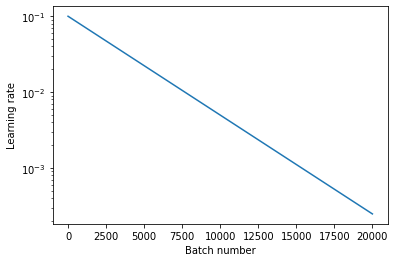

In [12]:
# Optimization hyperparameters
num_batchs = 20000        # Total number of batches to train on.
init_lr = 0.1          # initial learning rate
decay_factor = 0.9997     # decay the learning rate this much

learning_rate = optimizers.exponential_decay(init_lr, decay_steps=1, 
                                         decay_rate=decay_factor)

batch_idxs = np.linspace(1, num_batchs)
plt.semilogy(batch_idxs, [learning_rate(b) for b in batch_idxs])
plt.axis('tight')
plt.xlabel('Batch number')
plt.ylabel('Learning rate');

#### Train the Network

In [283]:
seed = 342343
prng_key = jax.random.PRNGKey(seed) # create a random key for jax for use on device.

########## MNIST data parameters ##########
smnist_params = {
  'mnist_classes': [0, 3, 8],
  'n_len' : 28,
  'time_dim': 'Rows'
}

smnist_params['n_inputs'] = int(28*28/smnist_params['n_len'])

########## RNN hyperparameters ##########
rnn_specs = {
  'cell_type': 'GRU',                               # Supports 'Vanilla', 'GRU', 'LSTM', or 'UGRNN'
  'input_size': smnist_params['n_inputs'],           # Number of inputs to the RNN
  'hidden_size': 128,                               # Number of units in the RNN
  'output_size': len(smnist_params['mnist_classes']),     # Number of outputs in the RNN
  'ro_bias': False,                                 # Include a bias with the readout
  'ro_simplex_init': False,
}

########## Train hyperparameters ##########

train_params = {
  'max_grad_norm': 10.0,      # max gradient norm before clipping, clip to this value.
  'l2reg': 1e-2,           # amount of L2 regularization on the weights

  'init_lr': 0.1,                     # initial learning rate
  'decay_factor': 0.9997,             # decay the learning rate this much
  'adam_b1': 0.9,                     # Adam parameters (b1=0.9, b2=0.99, eps=1e-8 are defaults)
  'adam_b2': 0.99,
  'adam_eps': 1e-1,

  'batch_size': 128,         # Total number of batches to train on.
  'print_every': 100,                     # Print training informatino every so often

  'epochs': 50,                               # How many times to go through each train set completely
}

train_params['decay_fun'] = optimizers.exponential_decay(train_params['init_lr'], decay_steps=1, decay_rate=train_params['decay_factor'])

# Sets default parameters if they weren't set above
# train_params, toy_params, rnn_specs = default_params(train_params, toy_params, rnn_specs)

########## Run ##########

print('MNIST Digits:', smnist_params['mnist_classes'])

new_network = True
load_network = False
save_data = True

path = '/content/drive/My Drive/ml_research/fixedpoints_nlp/smnist_data/gru_3class038_rowtime_noRO_l2is1e-2_2.pickle'
save_data = override_data(path, save_data)

if new_network:
  # Arrange MNIST
  train_jax, test_jax = convert_serialized_mnist(train_data, test_data, smnist_params, train_params)
  train_params['num_batchs'] = train_jax['inputs'].shape[0]

  val_data = {
        'inputs': test_jax['inputs'][0], # Phrase tensors: batch x phrase_len x in_dim
        'labels': test_jax['labels'][0], # Sentiment tensors: batch x phrase_len x out_dim
        'index': test_jax['index'][0], # Target mask: list of integers up to phrase_len
      }
  
  # Initialize the optimizer.  Please see jax/experimental/optimizers.py
  init_fun, apply_fun, mask_fun, loss_fun, accuracy_fun = build_rnn(rnn_specs)
  input_shape = (train_params['batch_size'], smnist_params['n_len'], smnist_params['n_inputs'])
  output_shape, initial_params = init_fun(prng_key, input_shape)

  opt = optimizers.adam(train_params['decay_fun'], train_params['adam_b1'], train_params['adam_b2'], train_params['adam_eps'])
  opt_state, step_fun = build_optimizer_step(opt, initial_params, loss_fun, gradient_clip=train_params['max_grad_norm'])
  
  init_opt, update_opt, get_params = opt

  train_params['train_losses'] = []
  train_params['global_step'] = 0
  train_params['total_steps'] = 0

elif load_network:
 
  raise NotImplementedError
  initial_params = params_loaded_jax
  output_shape = (train_params['batch_size'], toy_params['phrase_length'], len(toy_params['sentiments']))

  opt = optimizers.adam(train_params['decay_fun'], train_params['adam_b1'], train_params['adam_b2'], train_params['adam_eps'])
  opt_state, step_fun = build_optimizer_step(opt, initial_params, loss_fun, gradient_clip=train_params['max_grad_norm'])

  init_opt, update_opt, get_params = opt

  train_params['train_losses'] = train_params['train_losses'] if 'train_losses' in train_params else []
  train_params['global_step'] = train_params['total_steps']

else:

  raise NotImplementedError

# Generate synthetic data and run training on said data
opt_state, train_params = train_on_mnist(train_jax, val_data, opt_state, train_params, smnist_params, rnn_specs)

test_accuracy_final = full_test_accuracy(test_jax, opt_state, train_params, smnist_params, rnn_specs)
print('Full test accuracy:', test_accuracy_final)

train_params.pop('decay_fun') # Can't pickle with decay fun
save_run_data(path, save_data, get_params(opt_state), smnist_params, rnn_specs, train_params)

# Destructure the trained parameters of the RNN.
final_params = get_params(opt_state)
rnn_params, readout_params = final_params

MNIST Digits: [0, 3, 8]
Omitting incomplete batch
Omitting incomplete batch
Step 100 in 4.30 sec, step size: 0.09707, test acc 0.9219, avg training loss 1.7942
Step 200 in 0.93 sec, step size: 0.09420, test acc 0.9453, avg training loss 0.2890
Step 300 in 0.32 sec, step size: 0.09142, test acc 0.9453, avg training loss 0.0865
Step 400 in 1.55 sec, step size: 0.08872, test acc 0.9453, avg training loss 0.4004
Step 500 in 1.24 sec, step size: 0.08610, test acc 0.9609, avg training loss 0.3292
Step 600 in 0.67 sec, step size: 0.08355, test acc 0.9844, avg training loss 0.1620
Step 700 in 0.06 sec, step size: 0.08108, test acc 0.9297, avg training loss 0.0190
Step 800 in 1.53 sec, step size: 0.07868, test acc 0.9688, avg training loss 0.3871
Step 900 in 0.99 sec, step size: 0.07636, test acc 0.9844, avg training loss 0.2437
Step 1000 in 0.40 sec, step size: 0.07410, test acc 0.9766, avg training loss 0.0959
Step 1100 in 1.53 sec, step size: 0.07191, test acc 0.9766, avg training loss 0.353

In [186]:
# Save the network
path =  '/content/drive/My Drive/ml_research/fixedpoints_nlp/smnist_data/gru_3class018_noRO_l2is2e-3.pickle'

# train_params.pop('decay_fun')

save_data = override_data(path, True)
save_run_data(path, save_data, get_params(opt_state), smnist_params, rnn_specs, train_params)

Data Saved


In [293]:
# Loads network
path = '/content/drive/My Drive/ml_research/fixedpoints_nlp/data/gru_2class01_noRO_l2is2e-3.pickle'

with open(path, 'rb') as load_file:
    params_loaded = pickle.load(load_file)
    smnist_params = pickle.load(load_file)
    rnn_specs = pickle.load(load_file)
    train_params = pickle.load(load_file)

rnn_params, readout_params = params_loaded
# train_params, toy_params, rnn_specs = default_params(train_params, toy_params, rnn_specs)
print('Data Loaded')

FileNotFoundError: ignored

Text(0, 0.5, 'Train Loss')

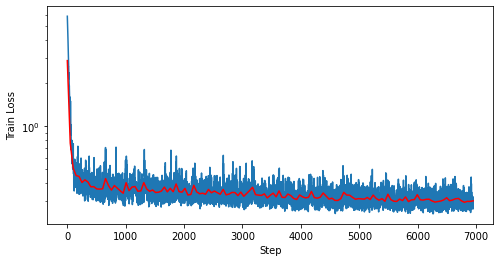

In [270]:
train_losses = train_params['train_losses']

plt.figure(figsize=(8, 4))
n_avg = 50
avg_loss = [1/n_avg * np.sum(train_losses[i*n_avg:(i+1)*n_avg]) for i in range(int(len(train_losses)/n_avg))]


plt.semilogy(np.linspace(1,len(train_losses),len(train_losses)), train_losses)
plt.semilogy(np.linspace(1,len(train_losses),int(len(train_losses)/n_avg)), avg_loss,'r')
plt.xlabel('Step')
plt.ylabel('Train Loss')

# Network Analysis

### Hidden State Analysis

In [245]:
from scipy.spatial.distance import pdist, squareform

def build_cell(rnn_specs):
  if 'cell_type' not in rnn_specs: rnn_specs['cell_type']  = 'GRU' # Default
  
  print('Using {} cell'.format(rnn_specs['cell_type']))
  if rnn_specs['cell_type'] == 'Vanilla':
    cell = renn.VanillaRNN(rnn_specs['hidden_size'])
  elif rnn_specs['cell_type'] == 'GRU':
    cell = renn.GRU(rnn_specs['hidden_size'])
  elif rnn_specs['cell_type'] == 'LSTM':
    cell = renn.LSTM(rnn_specs['hidden_size'])
  elif rnn_specs['cell_type'] == 'UGRNN':
    cell = renn.UGRNN(rnn_specs['hidden_size'])
  return cell

# Some helper functions to collect RNN hidden states.
@jax.jit
def _get_all_states(inputs, rnn_params):
  """Get RNN states in response to a batch of inputs (also returns masked states)."""
  initial_states = cell.get_initial_state(rnn_params, batch_size=inputs.shape[0])
  return renn.unroll_rnn(initial_states, inputs, functools.partial(cell.batch_apply, rnn_params))

def rnn_states(batch, rnn_params, only_final=False):
  """Return (masked) RNN states."""
  states = _get_all_states(batch['inputs'], rnn_params)
  if only_final: # returns only the final hidden state
    return [h[27] for h in states]
  else:
    return [h for h in states]

def keep_unique_fixed_points(fps, identical_tol=0.0, do_print=True):
  """Get unique fixed points by choosing a representative within tolerance.
  Args:
    fps: numpy array, FxN tensor of F fixed points of N dimension
    identical_tol: float, tolerance for determination of identical fixed points
    do_print: Print useful information? 
  Returns:
    2-tuple of UxN numpy array of U unique fixed points and the kept indices
  """
  keep_idxs = np.arange(fps.shape[0])
  if identical_tol <= 0.0:
    return fps, keep_idxs
  if fps.shape[0] <= 1:
    return fps, keep_idxs
  
  nfps = fps.shape[0]
  example_idxs = np.arange(nfps)
  all_drop_idxs = []

  # If point a and point b are within identical_tol of each other, and the
  # a is first in the list, we keep a.
  distances = squareform(pdist(fps, metric="euclidean"))
  for fidx in range(nfps-1):
    distances_f = distances[fidx, fidx+1:]
    drop_idxs = example_idxs[fidx+1:][distances_f <= identical_tol]
    all_drop_idxs += list(drop_idxs)
       
  unique_dropidxs = np.unique(all_drop_idxs)
  keep_idxs = np.setdiff1d(example_idxs, unique_dropidxs)
  if keep_idxs.shape[0] > 0:
    unique_fps = fps[keep_idxs, :]
  else:
    unique_fps = np.array([], dtype=np.int64)

  if do_print:
    print("    Kept %d/%d unique fixed points with uniqueness tolerance %f." %
          (unique_fps.shape[0], nfps, identical_tol))
    
  return unique_fps, keep_idxs

In [284]:
cell = build_cell(rnn_specs)

n_examples = 500

test_data_input_flat = test_jax['inputs'].reshape(test_jax['inputs'].shape[0]*test_jax['inputs'].shape[1], test_jax['inputs'].shape[2], test_jax['inputs'].shape[3])
test_data_label_flat = test_jax['labels'].reshape(test_jax['labels'].shape[0]*test_jax['labels'].shape[1], test_jax['labels'].shape[2], test_jax['labels'].shape[3])
test_data_index_flat = test_jax['index'].reshape(test_jax['index'].shape[0]*test_jax['index'].shape[1], test_jax['index'].shape[2])   

hs_data = {
    'inputs': test_data_input_flat[:n_examples],
    'labels': test_data_label_flat[:n_examples],
    'index': test_data_index_flat[:n_examples],
}

hs = rnn_states(hs_data, rnn_params, only_final=False)
pts = np.vstack(hs)[::2] # Gets every other state to eliminate states that are too close
print(pts.shape)

if rnn_specs['ro_bias']:
  wO, bO = readout_params
else:
  wO = readout_params
readout = wO.T
print('Readout shape:', readout.shape)

Using GRU cell
(7000, 128)
Readout shape: (3, 128)


Top 5 components: 0.9904707 ( [0.54128474 0.1952282  0.13238157 0.11184298 0.00973321] )
Category 0 states: 170
Category 1 states: 162
Category 2 states: 168
Readout vec proj via PCA: [[-1.007702   -2.4746962  -2.1611676 ]
 [ 0.20371513 -0.48464945  1.0822777 ]
 [-1.5135238  -0.955906   -1.7206961 ]
 [-1.9333494  -1.4021688  -0.9486143 ]
 [-0.04449832 -0.09028588 -0.09634249]]
h0 mag: 0.18323734


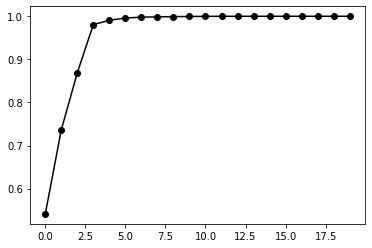

In [285]:
pc_dims = 5

# Finds percentage of variance explained by top pc_dims of PCA
pca_full = PCA(n_components=rnn_specs['hidden_size'])
_ = pca_full.fit_transform(pts)
explained_var = pca_full.explained_variance_ratio_
print('Top', pc_dims, 'components:', np.sum(explained_var[:pc_dims]), '(', explained_var[:pc_dims],')')
total_exvar = []
for i in range(rnn_specs['hidden_size']-1):
  total_exvar.append(np.sum(explained_var[:i+1]))
plt.figure()
plt.plot(total_exvar[:20], 'k-o')

# Group these states by the corresponding label.
states = []
for i in range(len(smnist_params['mnist_classes'])):
  states.append([h for h, lbl in zip(hs, hs_data['labels']) if np.argmax(lbl[smnist_params['n_len']-1]) == i])
  print('Category {} states:'.format(i), len(states[i]))

# We use principal components analysis (PCA) for visualization.
pca = PCA(n_components=pc_dims).fit(pts)
comp = pca.components_ # pc_dims x n_hidden
print('Readout vec proj via PCA:', pca.transform(readout).T)

# The initial state.
h0 = cell.get_initial_state(rnn_params)
h0.shape
print('h0 mag:', np.linalg.norm(h0))

Path label: [1. 0. 0.]
Path label: [0. 0. 1.]
Path label: [0. 1. 0.]


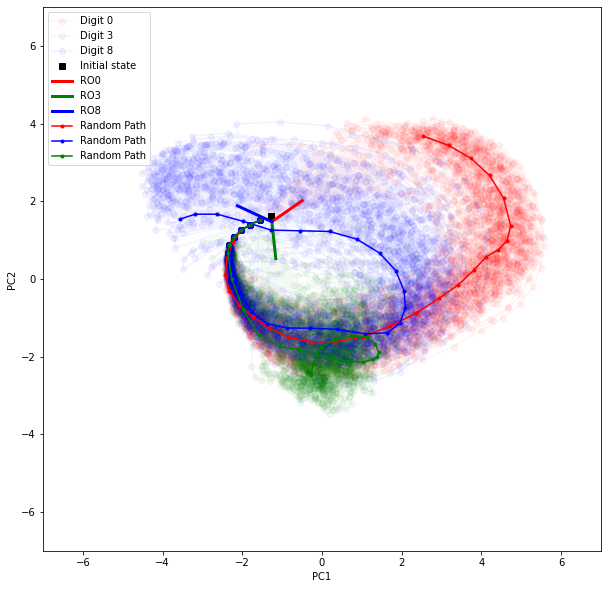

In [273]:
# Here, we visualize the hidden states of the RNN, projected into a
# low-dimensional 2D state space.

plt.figure(figsize=(10, 10))

pc1 = 0
pc2 = 1

# state_labels = ['Positive examples', 'Negative examples']
state_labels = ['Digit {}'.format(smnist_params['mnist_classes'][i]) for i in range(len(smnist_params['mnist_classes']))]
state_colors = ['r', 'g', 'b', 'y', 'orange', 'm']
for i in range(len(smnist_params['mnist_classes'])):
  if len(states[i]) > 0:
    pca_states = pca.transform(np.vstack(states[i])).T
    plt.plot(pca_states[pc1], pca_states[pc2], c = state_colors[i], marker='o', alpha=0.05, label=state_labels[i])

pca_h0 = pca.transform(np.atleast_2d(h0)).T
plt.plot(pca_h0[pc1], pca_h0[pc2], 'ks', label='Initial state')

# Plots readout direction
pca_ro = pca.transform(readout)
pca_zero = pca.transform(np.atleast_2d(np.zeros((128,)))).T
for i in range(len(readout)):
  # ro_dir = pca.transform(readout[i]).T #np.matmul(comp, readout[i])
  x_ro = [pca_zero[pc1], pca_ro[i][pc1]]
  y_ro = [pca_zero[pc2], pca_ro[i][pc2]]
  plt.plot(x_ro, y_ro, state_colors[i], linewidth = 3, label='RO'+str(smnist_params['mnist_classes'][i]))

path_idxs = [53, 452, 250]
for path_idx in path_idxs:
  path_pca = pca.transform(hs[path_idx]).T #np.matmul(comp, hs[path_idx].T)
  plt.plot(path_pca[pc1], path_pca[pc2], state_colors[np.argmax(hs_data['labels'][path_idx][27])], marker='.', label='Random Path')
  print('Path label:', hs_data['labels'][path_idx][27])

plt.xlabel('PC'+str(pc1+1))
plt.ylabel('PC'+str(pc2+1))
plot_coordinate = 7
plt.xlim(-plot_coordinate, plot_coordinate)
plt.ylim(-plot_coordinate, plot_coordinate)

plt.legend()

#### Readout Vector Analysis

In [250]:
def subspace_perc(A, b):
  """
  A: an N x M matrix, whose column space represents some M-dimensional subspace
  b: an N x 1 vector
  Finds the percentage of b's magnitude which lies in the subspace formed by the columns of A (its columnspace)
  """
  proj = np.matmul(np.matmul(A, np.linalg.inv(np.matmul(A.T, A))), A.T)
  b_proj = np.matmul(proj, b)

  return np.linalg.norm(b_proj)/np.linalg.norm(b)

# Percentage of readout vector mag in PCA dimensions

if rnn_specs['ro_bias']:
  wO, bO = readout_params
  print('Bias:', bO)
else:
  wO = readout_params
readout = wO.T

readout_mags = []
readout_pca_mags = []
pc_dims = 3
for i in range(len(readout)):
  readout_mags.append(np.linalg.norm(readout[i]))
  readout_pca_mags.append(np.linalg.norm(np.matmul(comp, readout.T).T[i][:pc_dims]))
  print('Readout {} mag:'.format(i), readout_mags[i])
  print('Readout {}'.format(i), '(perc in first {} PC dims):'.format(pc_dims), readout_pca_mags[i]/readout_mags[i])

print('Theoretical angle:', 180/np.pi * np.arccos(-1/(len(smnist_params['mnist_classes'])-1)))

for i in range(len(readout)):
  for j in range(i):
    print('Angle ({}, {}):'.format(i,j), 180/np.pi * np.arccos(np.dot(readout[i], readout[j])/(readout_mags[i]*readout_mags[j])))

for i in range(len(readout)):
  indices = []
  A = []
  for j in range(len(readout)):
    if i != j:
      A.append(readout[j])
      indices.append(j)
  print('Perc of {} in {}:'.format(i, indices), subspace_perc(np.asarray(A).T, readout[i]))

Readout 0 mag: 0.8458252
Readout 0 (perc in first 3 PC dims): 0.9959386
Readout 1 mag: 1.2052283
Readout 1 (perc in first 3 PC dims): 0.9805708
Readout 2 mag: 0.9182871
Readout 2 (perc in first 3 PC dims): 0.9710048
Readout 3 mag: 0.9518491
Readout 3 (perc in first 3 PC dims): 0.9961678
Theoretical angle: 109.47122063449069
Angle (1, 0): 105.67838072535145
Angle (2, 0): 109.91931348290406
Angle (2, 1): 117.59055848693384
Angle (3, 0): 102.57940778570077
Angle (3, 1): 125.38921383974105
Angle (3, 2): 94.34489757138755
Perc of 0 in [1, 2, 3]: 1.0000002
Perc of 1 in [0, 2, 3]: 1.0000001
Perc of 2 in [0, 1, 3]: 1.0
Perc of 3 in [0, 1, 2]: 1.0000004


In [193]:
# Exact symplex numbers

simplex = []
simplex.append(np.asarray([1,0,0]))
simplex.append(np.asarray([-1/3, np.sqrt(8)/3, 0]))
simplex.append(np.asarray([-1/3, -np.sqrt(2)/3, np.sqrt(2/3)]))
simplex.append(np.asarray([-1/3, -np.sqrt(2)/3, -np.sqrt(2/3)]))

read_out_mags = []
for i in range(len(simplex)):
  read_out_mags.append(np.linalg.norm(simplex[i]))

print(read_out_mags)

for i in range(len(simplex)):
  for j in range(i):
    print('Angle ({}, {}):'.format(i,j), 180/np.pi * np.arccos(np.dot(simplex[i], simplex[j])/(read_out_mags[i]*read_out_mags[j])))

A01 = np.array([simplex[0], simplex[1]]).T
A02 = np.array([simplex[0], simplex[2]]).T
A12 = np.array([simplex[1], simplex[2]]).T

print('Perc of 2 in (0,1):', subspace_perc(A01, simplex[2]))
print('Perc of 1 in (0,2):', subspace_perc(A02, simplex[1]))
print('Perc of 0 in (1,2):', subspace_perc(A12, simplex[0]))

[1.0, 1.0, 1.0, 1.0]
Angle (1, 0): 109.47122063449069
Angle (2, 0): 109.47122063449069
Angle (2, 1): 109.47122063449069
Angle (3, 0): 109.47122063449069
Angle (3, 1): 109.47122063449069
Angle (3, 2): 109.47122063449069
Perc of 2 in (0,1): 0.5773502691896258
Perc of 1 in (0,2): 0.5773502691896258
Perc of 0 in (1,2): 0.5773502691896257


### Find Fixed Points

In [274]:
phrase_means = np.zeros((train_jax['inputs'].shape[0], train_jax['inputs'].shape[1], 28))

for batch in range(train_jax['inputs'].shape[0]):
  batch_data = {'inputs': test_jax['inputs'][batch]} # Phrase tensors: batch x phrase_len x in_dim
  for batch_idx in range(batch_data['inputs'].shape[0]):
      phrase_means[batch, batch_idx] = np.mean(batch_data['inputs'][batch_idx], axis=0) # Averages over phrase

mean_input = np.mean(np.mean(phrase_means, axis=0), axis=0) # Batches and batch index
print('Mean input:', mean_input)

Mean input: [0.00000000e+00 7.47826169e-07 1.32080274e-03 5.00332702e-03
 1.53679772e-02 4.56638164e-02 8.92736057e-02 1.43745195e-01
 2.04064990e-01 2.48779452e-01 2.79400477e-01 3.08473030e-01
 3.18309366e-01 3.13227749e-01 3.12388897e-01 3.22296241e-01
 3.26113306e-01 3.08590952e-01 2.83027021e-01 2.57508197e-01
 2.14104010e-01 1.52407169e-01 9.12500090e-02 4.23122880e-02
 1.25079986e-02 1.31605599e-03 1.81147109e-04 1.28311227e-05]


In [279]:
word_tensor = jnp.zeros(rnn_specs['input_size'])

# xstar = jnp.zeros((pts.shape[0], rnn_specs['input_size']))
pts_ones = jnp.ones((pts.shape[0],))
xstar = jnp.outer(pts_ones, jnp.asarray(mean_input))

fp_loss_fun = renn.build_fixed_point_loss(cell, rnn_params)
fixed_points, loss_hist, fp_losses = renn.find_fixed_points(fp_loss_fun, pts, xstar, optimizers.adam(0.01),
                                                            tolerance=1e-2, num_steps=10000)
print('Done')

  0%|          | 1/10000 [00:00<1:02:30,  2.67it/s]

Done


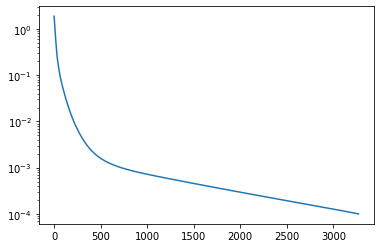

In [ ]:
plt.semilogy(loss_hist)

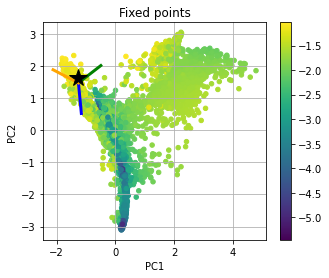

In [280]:
# 2D Visualization of the approximate fixed points: the line attractor.

pc1 = 0
pc2 = 1

plt.figure(figsize=(5, 4))
pca_fps = pca.transform(np.vstack(fixed_points)).T
plt.scatter(pca_fps[pc1], pca_fps[pc2], s=20, c=np.log10(fp_losses))
plt.grid()

plt.colorbar()

# pca_word = 1*word_deflection('kinda0', cell, toy_params, rnn_params, rnn_specs, fixed_points[fp_idx], comp)
# plt.plot([pca_h0[pc1], pca_word[pc1]], [pca_h0[pc2], pca_word[pc2]], color='k')
# pca_word = 1*word_deflection('kinda1', cell, toy_params, rnn_params, rnn_specs, fixed_points[fp_idx], comp)
# plt.plot([pca_h0[pc1], pca_word[pc1]], [pca_h0[pc2], pca_word[pc2]], color='r')
# pca_word = 3*word_deflection('kinda01', cell, toy_params, rnn_params, rnn_specs, h0, comp)
# plt.plot([pca_h0[pc1], pca_word[pc1]], [pca_h0[pc2], pca_word[pc2]], color='b')

# Plots readout direction
ro_colors = ['g', 'b', 'orange', 'm', 'r']
pca_ro = pca.transform(readout)
pca_zero = pca.transform(np.atleast_2d(np.zeros((128,)))).T
for i in range(len(readout)):
  x_ro = [pca_zero[pc1], pca_ro[i][pc1]]
  y_ro = [pca_zero[pc2], pca_ro[i][pc2]]
  plt.plot(x_ro, y_ro, ro_colors[i], linewidth = 3)

pca_h0 = pca.transform(np.atleast_2d(h0)).T
plt.plot(pca_h0[pc1], pca_h0[pc2], '*', color='k', ms=18)
plt.title('Fixed points')

plt.xlabel('PC'+str(pc1+1))
plt.ylabel('PC'+str(pc2+1))
plot_coordinate = None
if plot_coordinate != None:
  plt.xlim(-plot_coordinate, plot_coordinate)
  plt.ylim(-plot_coordinate, plot_coordinate)

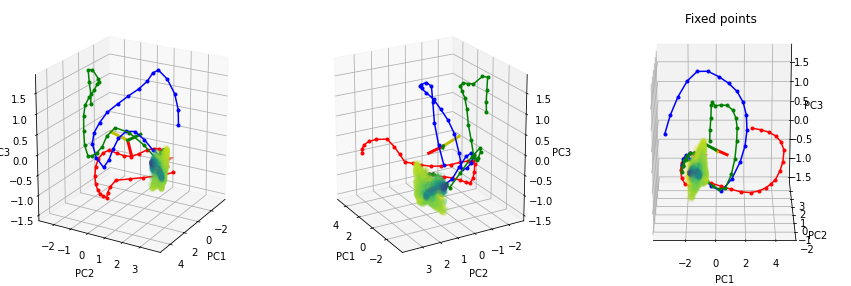

In [278]:
# triangulate in the underlying parametrization
from matplotlib.tri import Triangulation

pc1 = 0
pc2 = 1
pc3 = 2

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(131, projection='3d');
ax2 = fig.add_subplot(132, projection='3d');
ax3 = fig.add_subplot(133, projection='3d');


pca_fps = pca.transform(np.vstack(fixed_points)).T
# max_loss = np.max(np.log10(fp_losses))
# min_loss = np.min(np.log10(fp_losses))
# loss_range = max_loss - min_loss
# colors = []
# for loss in fp_losses:
#   seq_color_norm = (np.log10(loss)-min_loss)/loss_range
#   colors.append((seq_color_norm, 0, 1 - seq_color_norm, 1.0))
# ax.plot_trisurf(pca_fps[pc1], pca_fps[pc2], pca_fps[pc3], edgecolor='none', color='grey')
ax.scatter(pca_fps[pc1], pca_fps[pc2], pca_fps[pc3], s=20, c=np.log10(fp_losses), alpha=0.1)
ax2.scatter(pca_fps[pc1], pca_fps[pc2], pca_fps[pc3], s=20, c=np.log10(fp_losses), alpha=0.1)
ax3.scatter(pca_fps[pc1], pca_fps[pc2], pca_fps[pc3], s=20, c=np.log10(fp_losses), alpha=0.1)

pca_h0 = pca.transform(np.atleast_2d(h0)).T
ax.plot(pca_h0[pc1], pca_h0[pc2], pca_h0[pc3], '*', color='lightcoral', ms=18)
ax2.plot(pca_h0[pc1], pca_h0[pc2], pca_h0[pc3], '*', color='lightcoral', ms=18)
ax3.plot(pca_h0[pc1], pca_h0[pc2], pca_h0[pc3], '*', color='lightcoral', ms=18)
plt.title('Fixed points')

# Plots readout direction
ro_colors = ['r', 'y', 'g', 'b', 'm']
for i in range(len(readout)):
  ro_dir = np.matmul(comp, readout[i])
  x_ro = [0, ro_dir[pc1]]
  y_ro = [0, ro_dir[pc2]]
  z_ro = [0, ro_dir[pc3]]
  ax.plot(x_ro, y_ro, z_ro, ro_colors[i], linewidth = 3)
  ax2.plot(x_ro, y_ro, z_ro, ro_colors[i], linewidth = 3)
  ax3.plot(x_ro, y_ro, z_ro, ro_colors[i], linewidth = 3)

# pca_word = 3*word_deflection('very1', cell, toy_params, rnn_params, rnn_specs, h0, comp)
# plt.plot([pca_h0[pc1], pca_word[pc1]], [pca_h0[pc2], pca_word[pc2]], color='k')
# pca_word = 3*word_deflection('very0', cell, toy_params, rnn_params, rnn_specs, h0, comp)
# plt.plot([pca_h0[pc1], pca_word[pc1]], [pca_h0[pc2], pca_word[pc2]], color='r')
# pca_word = 3*word_deflection('kinda01', cell, toy_params, rnn_params, rnn_specs, h0, comp)
# plt.plot([pca_h0[pc1], pca_word[pc1]], [pca_h0[pc2], pca_word[pc2]], color='b')

ax.set_xlabel('PC'+str(pc1+1))
ax.set_ylabel('PC'+str(pc2+1))
ax.set_zlabel('PC'+str(pc3+1))
ax2.set_xlabel('PC'+str(pc1+1))
ax2.set_ylabel('PC'+str(pc2+1))
ax2.set_zlabel('PC'+str(pc3+1))
ax3.set_xlabel('PC'+str(pc1+1))
ax3.set_ylabel('PC'+str(pc2+1))
ax3.set_zlabel('PC'+str(pc3+1))


for path_idx in path_idxs:
  path_pca = pca.transform(hs[path_idx]).T #np.matmul(comp, hs[path_idx].T)
  ax.plot(path_pca[pc1], path_pca[pc2], path_pca[pc3], state_colors[np.argmax(hs_data['labels'][path_idx][27])], marker='.',)
  ax2.plot(path_pca[pc1], path_pca[pc2], path_pca[pc3], state_colors[np.argmax(hs_data['labels'][path_idx][27])], marker='.',)
  ax3.plot(path_pca[pc1], path_pca[pc2], path_pca[pc3], state_colors[np.argmax(hs_data['labels'][path_idx][27])], marker='.',)

# Azimuthal angle and rotation
more_rot = 30
ax.view_init(20, 0 + more_rot)
ax2.view_init(20, 120 + more_rot)
ax3.view_init(20, 240 + more_rot)

#### Single Fixed Point Analysis

Text(0, 0.5, 'PC2')

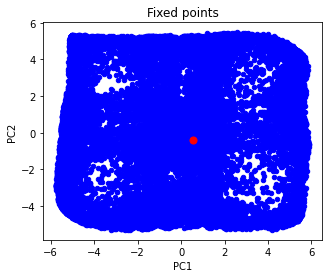

In [ ]:
# Pick a fixed point.
# fp_idx = np.argmin(fp_losses)
fp_idx = 350
fp = fixed_points[fp_idx]

# 2D Visualization of where said fixed point is
pc1 = 0
pc2 = 1

plt.figure(figsize=(5, 4))
pca_fps = pca.transform(np.vstack(fixed_points)).T
plt.scatter(pca_fps[pc1], pca_fps[pc2], s=20, c='b')
plt.scatter(pca_fps[pc1][fp_idx], pca_fps[pc2][fp_idx], s=50, c='r')

plt.title('Fixed points')

plt.xlabel('PC'+str(pc1+1))
plt.ylabel('PC'+str(pc2+1))

In [ ]:
# Computes the recurrent Jacobian.
jac = jax.device_get(cell.rec_jac(rnn_params, jnp.zeros(rnn_specs['input_size']), fp))

# Perform an eigendecomposition to get eigenvectors and eigenvalues.
R, E, L = renn.eigsorted(jac)

Text(0, 0.5, 'imag')

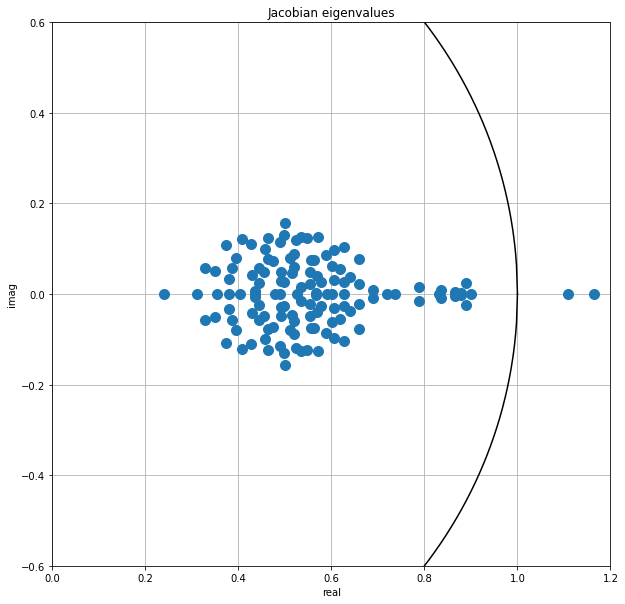

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(np.real(E), np.imag(E), 'o', ms=10)
plt.grid()
plt.xlim(0, 1.2)
plt.ylim(-0.6, 0.6)
# Makes unit circle
x = np.linspace(-1, 1, 1000)
plt.plot(x, np.sqrt(1-x**2), 'k')
plt.plot(x, -np.sqrt(1-x**2), 'k')

plt.title('Jacobian eigenvalues')
plt.xlabel('real')
plt.ylabel('imag')

#### Many Fixed Point Analysis

In [ ]:
# Jacobian projections
def word_deflection(word, cell, toy_params, rnn_params, rnn_specs, hs, comp):
  """ Returns (linearized) deflection of word from hs in terms of pcs of comp""" 
  word_tensor = wordToTensor(word, toy_params['words'])
  input_jac = cell.inp_jac(rnn_params, jnp.zeros(rnn_specs['input_size']), hs)
  hidden_update = np.matmul(input_jac, word_tensor[0])
  
  return np.matmul(comp, hidden_update)

def hs_modes(n_eigs, cell, toy_params, rnn_params, rnn_specs, hs, comp):
  """ Returns deflection of top n_eigs eigenvalues from hs in terms of pcs of comp""" 
  jac = jax.device_get(cell.rec_jac(rnn_params, jnp.zeros(rnn_specs['input_size']), hs))
  R, E, L = renn.eigsorted(jac)

  print('HS top eigenvalues:', E[:n_eigs+1])

  return np.matmul(comp, R[:, :n_eigs]).T

In [ ]:
# Plots Jacobian eigenvalues as a function of fixed point

pca_fps = pca.transform(np.vstack(fixed_points)).T

# Sorts fixed points by pc dimension
# sort_idxs = np.argsort(pca_fps[0])
# sorted_pca_fps = pca_fps[0][sort_idxs]
# sorted_fp = fixed_points[sort_idxs]

# Sorts fixed points by distance from mean fixed point
fp_mean = np.mean(fixed_points, axis=0)
fp_dist = np.zeros((fixed_points.shape[0],))
for fp_idx in range(fixed_points.shape[0]):
  fp_dist[fp_idx] = np.linalg.norm(fixed_points[fp_idx]-fp_mean, ord=1)
sort_idxs = np.argsort(fp_dist)
sorted_fpidx = fp_dist[sort_idxs]
sorted_fp = fixed_points[sort_idxs]


take_every = 25
n_top = 8
n_fp = len(fixed_points)
print('Evaluating {} fixed points.'.format(n_fp))
max_evals = np.zeros((int(n_fp/take_every), n_top))
max_evals_im = np.zeros((int(n_fp/take_every), n_top))
pc_dim_val = np.zeros(int(n_fp/take_every))

for i in tqdm(range(0, int(n_fp/take_every))):
  fp = sorted_fp[i*take_every]
  jac = jax.device_get(cell.rec_jac(rnn_params, jnp.zeros(rnn_specs['input_size']), fp))
  _, E, _ = renn.eigsorted(jac)
  rE = np.real(E)
  iE = np.imag(E)
  rE.sort()
  iE.sort()
  pc_dim_val[i] = sorted_fpidx[i*take_every]
  max_evals[i] = rE[-n_top:]
  max_evals_im[i] = iE[-n_top:]

Evaluating 10000 fixed points.


Text(0, 0.5, 'Top Im(Eigenvalues)')

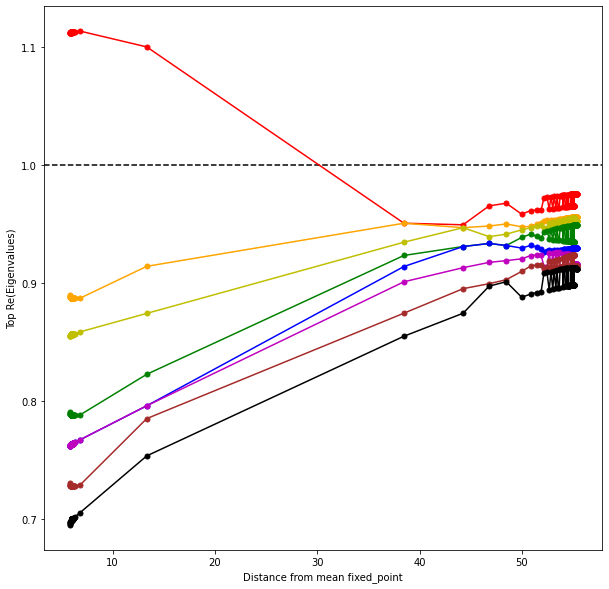

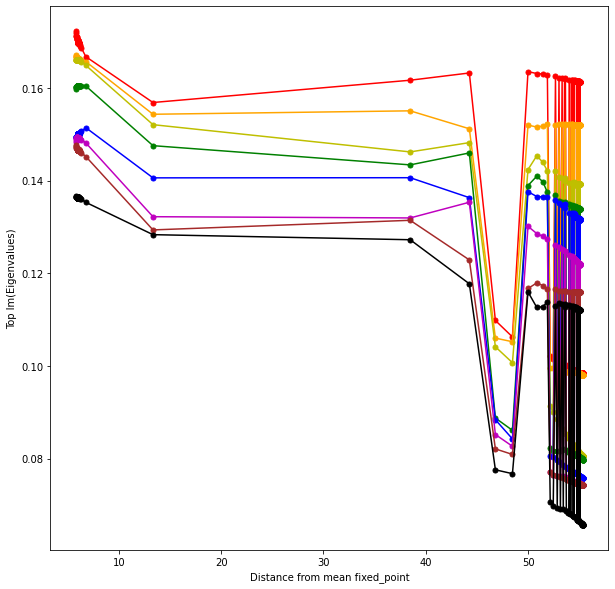

In [ ]:
plt.figure(figsize=(10,10))
plt.axhline(1.0, c='k', linestyle='--')
colors = ['r', 'orange', 'y', 'g', 'b', 'm', 'brown', 'k']
for i in range(n_top):
  plt.plot(pc_dim_val, max_evals[:,n_top-1-i], '.-', ms=10, c=colors[i])

plt.xlabel('PC1')
plt.xlabel('Distance from mean fixed_point')
plt.ylabel('Top Re(Eigenvalues)')

plt.figure(figsize=(10,10))
colors = ['r', 'orange', 'y', 'g', 'b', 'm', 'brown', 'k']
for i in range(n_top):
  plt.plot(pc_dim_val, max_evals_im[:,n_top-1-i], '.-', ms=10, c=colors[i])

plt.xlabel('PC1')
plt.xlabel('Distance from mean fixed_point')
plt.ylabel('Top Im(Eigenvalues)')

In [ ]:
print('Number of fixed points:', len(fixed_points))

Number of fixed points: 25000


HS top eigenvalues: [0.8956536+0.j 0.8526117+0.j 0.8031965+0.j]
HS top eigenvalues: [0.89565367+0.j 0.8526116 +0.j 0.8031965 +0.j]
HS top eigenvalues: [1.1041673 +0.j 0.86134094+0.j 0.8294861 +0.j]
HS top eigenvalues: [1.1124028 +0.j 0.8614164 +0.j 0.81864643+0.j]
HS top eigenvalues: [1.0988455 +0.j 0.85771126+0.j 0.8039921 +0.j]


Text(0, 0.5, 'PC2')

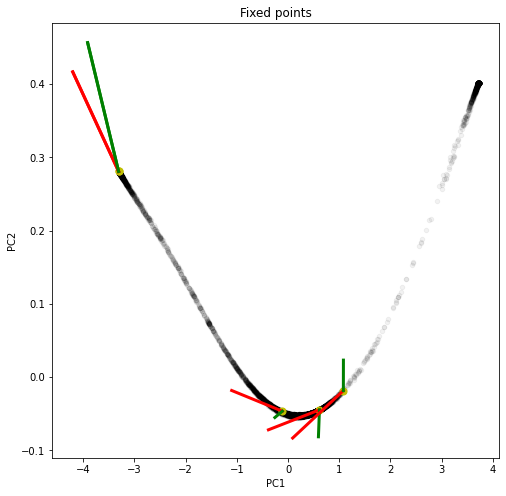

In [ ]:
# Zero modes
fp_idxs =[600, 1000, 4000, 22000, 24000]
num_eigs = 2
scale = 1 # Amount to scale up eigenvalues

# 2D Visualization of where said fixed point is
pc1 = 0
pc2 = 1
plt.figure(figsize=(8, 8))

# Sorts fixed points by pc1 dimension
pca_fps = pca.transform(np.vstack(fixed_points)).T
sort_idxs = np.argsort(pca_fps[pc1])
sorted_fp = fixed_points[sort_idxs]

pca_fps = pca.transform(np.vstack(sorted_fp)).T
plt.scatter(pca_fps[pc1], pca_fps[pc2], alpha=0.05, s=20, c='k')

eig_colors = ['r', 'g', 'm', 'b', 'orange', 'grey']
for fp_idx in fp_idxs:
  mode_proj = scale * np.real(hs_modes(num_eigs, cell, toy_params, rnn_params, rnn_specs, sorted_fp[fp_idx], comp))
  for i in range(num_eigs):
    plt.plot(pca_fps[pc1][fp_idx] + [0, mode_proj[i][pc1]], pca_fps[pc2][fp_idx] + [0, mode_proj[i][pc2]], eig_colors[i], linewidth=3)
  plt.scatter(pca_fps[pc1][fp_idx], pca_fps[pc2][fp_idx], s=50, c='y')

plt.title('Fixed points')

plt.xlabel('PC'+str(pc1+1))
plt.ylabel('PC'+str(pc2+1))

In [ ]:
word_tensor = wordToTensor('not', toy_params['words'])

# Finds deflection of RNNs for a given input
ref_idx = 400
ref_fp = fixed_points[ref_idx]
def_state = cell.apply(rnn_params, word_tensor[0], ref_fp)
delta_hnot_ref = def_state - ref_fp
delta_hnot_ref_mag = np.linalg.norm(delta_hnot_ref)

# Sorts fixed points by pc1 dimension
pca_fps = pca.transform(np.vstack(fixed_points)).T
sort_idxs = np.argsort(pca_fps[0])
sorted_pca_fps = pca_fps[0][sort_idxs]
sorted_fp = fixed_points[sort_idxs]

take_every = 10
n_fp = len(fixed_points)
n_eval = int(n_fp/take_every)

def_state = np.zeros((n_eval, rnn_specs['hidden_size']))
delta_hnot = np.zeros((n_eval, rnn_specs['hidden_size']))
hnot_angles = np.zeros((n_eval,))
hnot_mags = np.zeros((n_eval,))
pc_dim_val = np.zeros((n_eval,))
for i in tqdm(range(0, n_eval)):
  def_state[i] = cell.apply(rnn_params, word_tensor[0], sorted_fp[i*take_every])
  delta_hnot[i] = def_state[i] - sorted_fp[i*take_every]
  pc_dim_val[i] = sorted_pca_fps[i*take_every]
  hnot_mags[i] = np.linalg.norm(delta_hnot[i])
  hnot_angles[i] = 180/np.pi * np.arccos(np.dot(delta_hnot[i], delta_hnot_ref)/(hnot_mags[i]*delta_hnot_ref_mag))

delta_hnot_mean = np.mean(delta_hnot)
hnot_perc_diff = np.zeros((n_eval,))
for i in range(0, n_eval):
  mean_diff = delta_hnot[i] - delta_hnot_mean
  hnot_perc_diff[i] = np.linalg.norm(mean_diff)/hnot_mags[i]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in arccos


Text(0, 0.5, 'Perc diff from mean')

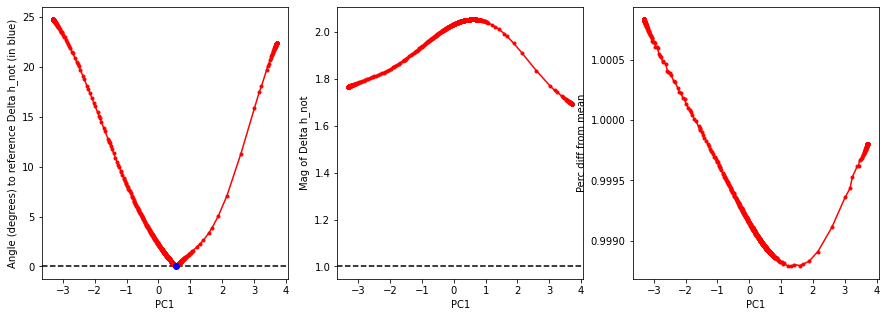

In [ ]:
plt.figure(figsize=(15,5))
ax1 = plt.subplot('131')
ax1.axhline(0.0, c='k', linestyle='--')
ax1.plot(pc_dim_val, hnot_angles, 'r-', marker='.')
ax1.plot(pca_fps[0][ref_idx], [0.0], 'b-o')

ax1.set_xlabel('PC1')
ax1.set_ylabel('Angle (degrees) to reference Delta h_not (in blue)')

ax2 = plt.subplot('132')
ax2.axhline(1.0, c='k', linestyle='--')
ax2.plot(pc_dim_val, hnot_mags, 'r-', marker='.')

ax2.set_xlabel('PC1')
ax2.set_ylabel('Mag of Delta h_not')

ax3 = plt.subplot('133')
ax3.plot(pc_dim_val, hnot_perc_diff, 'r-', marker='.')

ax3.set_xlabel('PC1')
ax3.set_ylabel('Perc diff from mean')

Text(0, 0.5, 'PC2')

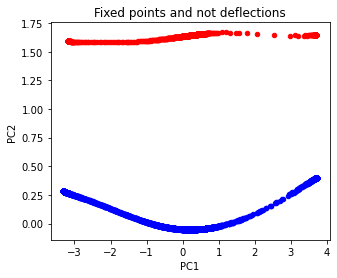

In [ ]:
# Plots fixed points and deflected states

# 2D Visualization of where said fixed point is
pc1 = 0
pc2 = 1

plt.figure(figsize=(5, 4))
pca_fps = pca.transform(np.vstack(fixed_points)).T
plt.scatter(pca_fps[pc1], pca_fps[pc2], s=20, c='b')

pca_defs = pca.transform(np.vstack(def_state)).T
plt.scatter(pca_defs[pc1], pca_defs[pc2], s=20, c='r')

plt.title('Fixed points and not deflections')

plt.xlabel('PC'+str(pc1+1))
plt.ylabel('PC'+str(pc2+1))

#### Readout Space Projection

x 1.0
y 1.0
x.y -6.3329935e-08


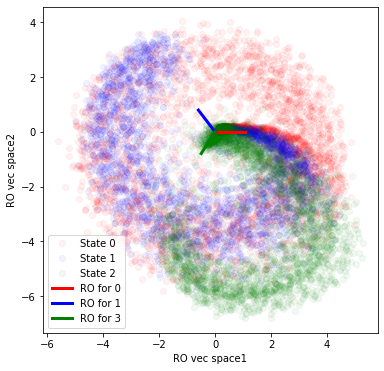

In [78]:
# Project hidden states onto the readout space
ro1 = 0
ro2 = 1

# Creates basis vectors for the readout space
x_basis = readout[ro1] / np.linalg.norm(readout[ro1])
y_vec = readout[ro2] - np.dot(x_basis, readout[ro2]) * x_basis
y_basis = y_vec / np.linalg.norm(y_vec)
print('x', np.linalg.norm(x_basis))
print('y', np.linalg.norm(y_basis))
print('x.y', np.dot(x_basis, y_basis))

A = np.array([x_basis, y_basis]).T
proj = np.matmul(np.matmul(A, np.linalg.inv(np.matmul(A.T, A))), A.T) # 2 x n_hidden
plt.figure(figsize=(6, 6))

# state_labels = ['Positive examples', 'Negative examples']
state_labels = ['State {}'.format(i) for i in range(rnn_specs['output_size'])]
state_colors = ['r', 'b', 'g', 'b', 'm']
for i in range(rnn_specs['output_size']):
  x_vals = np.dot(np.matmul(np.vstack(states[i]), proj), x_basis)
  y_vals = np.dot(np.matmul(np.vstack(states[i]), proj), y_basis)
  plt.plot(x_vals, y_vals, state_colors[i]+'o', alpha=0.05, label=state_labels[i])

ro_colors = ['r', 'b', 'g', 'b', 'm']
for i in range(len(readout)):
  ro_proj = np.matmul(proj, readout[i])
  plt.plot([0, np.dot(x_basis, ro_proj)], [0, np.dot(y_basis, ro_proj)], ro_colors[i], 
           linewidth = 3, label='RO for '+str(smnist_params['mnist_classes'][i]))

plt.xlabel('RO vec space1')
plt.ylabel('RO vec space2')
plt.legend()

# plt.xlim(-7, 7)
# plt.ylim(-7, 7)

x 1.0
y 1.0
x.y -6.3329935e-08


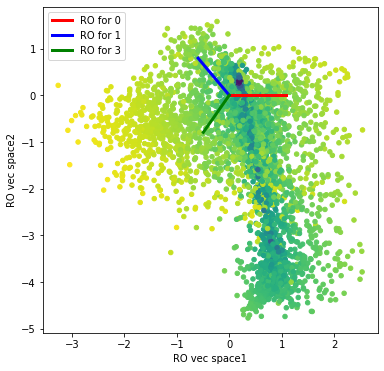

In [79]:
# Project fixed points onto the readout space
ro1 = 0
ro2 = 1

# Creates basis vectors for the readout space
x_basis = readout[ro1] / np.linalg.norm(readout[ro1])
y_vec = readout[ro2] - np.dot(x_basis, readout[ro2]) * x_basis
y_basis = y_vec / np.linalg.norm(y_vec)
print('x', np.linalg.norm(x_basis))
print('y', np.linalg.norm(y_basis))
print('x.y', np.dot(x_basis, y_basis))

A = np.array([x_basis, y_basis]).T
proj = np.matmul(np.matmul(A, np.linalg.inv(np.matmul(A.T, A))), A.T) # 2 x n_hidden
plt.figure(figsize=(6, 6))

# Fixed points
x_vals = np.dot(np.matmul(np.vstack(fixed_points), proj), x_basis)
y_vals = np.dot(np.matmul(np.vstack(fixed_points), proj), y_basis)
plt.scatter(x_vals, y_vals, s=20, c=np.log10(fp_losses))
plt.colorbar

ro_colors = ['r', 'b', 'g', 'b', 'm']
for i in range(len(readout)):
  ro_proj = np.matmul(proj, readout[i])
  plt.plot([0, np.dot(x_basis, ro_proj)], [0, np.dot(y_basis, ro_proj)], ro_colors[i], linewidth = 3, 
           label='RO for '+str(smnist_params['mnist_classes'][i]))

plt.xlabel('RO vec space1')
plt.ylabel('RO vec space2')
plt.legend()

### FP Manifold Dimension


In [ ]:
unique_tol = 0.025
do_print = True
fps_reduced, unique_kidxs = keep_unique_fixed_points(fixed_points, unique_tol, do_print)
# fps_reduced = fixed_points
n_fp = fps_reduced.shape[0]

time1 = time.time()
distances = pdist(fps_reduced, metric="euclidean") # n_fp * (n_fps-1) / 2
dist_sq = squareform(distances) # n_fp x n_fp 
print('Scipy Eucl Dist Time: {:0.2f} sec.'.format(time.time() - time1))
distances.sort()
print('Min dist:', distances[0])
print('Max dist:', distances[-1])

    Kept 2299/10000 unique fixed points with uniqueness tolerance 0.025000.
Scipy Eucl Dist Time: 0.26 sec.
Min dist: 0.02500274664486267
Max dist: 11.167172991811269


In [ ]:
def find_m_k(k, dist_sq):
  """
  Calculates m_k from Levina, Bickel (Eq. (9))
  
  k: Number of nearest neighbors
  dist_sq: n x n matrix of Euclidean distances between points
  """

  n = dist_sq.shape[0]
  
  m_ks = np.zeros((n,))
  k_eff = k + 1 # Self-distance included, so bump k up by one

  for idx in range(n): # Calculate m_k(x) for all x
    idx_dists = dist_sq[idx, :]
    kidxs = np.argpartition(idx_dists, k_eff)
    max_kdist = np.max(idx_dists[kidxs[:k_eff]])
    sum_of_logs = 0
    for i in range(k_eff):
      if idx_dists[kidxs[i]] > 0: # Ignores self distance
        sum_of_logs += np.log(max_kdist / idx_dists[kidxs[i]])
    m_ks[idx] = 1 / (1/(k - 1) * sum_of_logs)

  return np.mean(m_ks)


# k_vals = np.asarray([int(k_val) for k_val in range(50,80)])
# m_k_means = []
# for k_val in k_vals:
#   m_ks = np.zeros((n_fp,))
#   for i in range(n_fp):
#     m_ks[i] = find_m_k(i, k_val, dist_sq)
#   m_k_means.append(np.mean(m_ks))

k_val = 200
m_k_val = find_m_k(k_val, dist_sq)
print('m_k average:', m_k_val)

m_k average: 1.3098089897964853


k_avged Estimate: 2.033284748961476


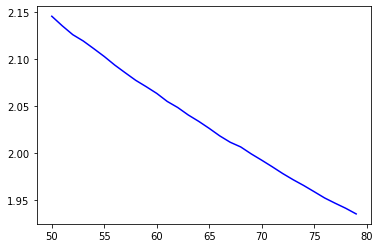

In [ ]:
print('k_avged Estimate:', 1/(np.max(k_vals)-np.min(k_vals)+1)*np.sum(m_k_means))

plt.figure()
plt.plot(k_vals, m_k_means, 'b')

Slope: 1.1424838189591549


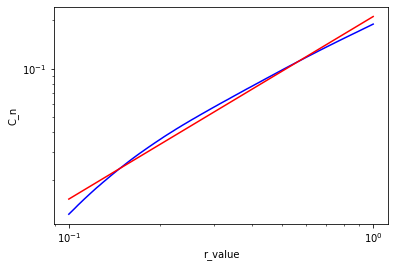

In [ ]:
import scipy
from scipy.spatial.distance import squareform

def find_correlation_dimension(r_val_range, dist_sq, num_pts=100, show_plot=False):
  """ 
  Calculates the linear regression fit of correlation dimension(r). The slope of said result is the estimated dimension

  r_val_range: log10(Range) of r values, specifically np.logspace(r[0], r[1]), 100)
  dist_sq: n x n matrix of Euclidean distances between points
  num_pts: number of points to fit

  Output: slope, intercept, r_value, p_value, std_err of linear regression fit
  """
  n = dist_sq.shape[0]
  distances = squareform(dist_sq)  # Changes to n * (n-1) / 2 vector
  r_values = np.logspace(r_val_range[0], r_val_range[1], num_pts)

  thresh_count = np.asarray([np.count_nonzero(distances < r_val) for r_val in r_values])
  c_n = 2/(n*(n - 1)) * thresh_count

  slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(np.log10(r_values), np.log10(c_n))

  if show_plot: # Shows plot of fit
    plt.figure()
    plt.loglog(r_values, c_n, 'b')

    y_fit_values = np.asarray([10**intercept * r_val**slope for r_val in r_values])
    plt.loglog(r_values, y_fit_values, 'r')

    plt.xlabel('r_value')
    plt.ylabel('C_n')

  return slope, intercept, r_value, p_value, std_err

# r_range = (np.log10(1.1*distances[0]),np.log10(distances[-1])z)
r_range = (-1, 0)
slope, _, _, _, _ = find_correlation_dimension(r_range, dist_sq, show_plot=True)
print('Slope:', slope)

### Training Paths

#### Rotation/Reflection

In [ ]:
cell = build_cell(rnn_specs)

# Get RNN hidden states in response to a test batch.
n_trials = 400

syn_data_test = generate_data(n_trials, toy_params, rnn_specs['output_size'])

hs = rnn_states(syn_data_test, rnn_params)
pts = np.vstack(hs)[::2] # Gets every other state to eliminate states that are too close

pca_full = PCA(n_components=rnn_specs['hidden_size']).fit(pts)
comp = pca_full.components_ # pc_dims x n_hidden

pc_dims = 2

syn_data_path = generate_data(1, toy_params, rnn_specs['output_size'])
hs_path = rnn_states(syn_data_path, rnn_params)[0]
pca_path = np.matmul(hs_path, comp.T) # length x pc_dims

print(syn_data_path['inputs'][0][:5])
print(tensorToPhrase(syn_data_path['inputs'][0], toy_params['words'])[:5])
path_label = np.argmax(syn_data_path['labels'][0, toy_params['phrase_length']-1])

# # Finds percent of hidden states magnitude explained in first few PCA dimensions
# pca_dims = 3
# perc_mag_hs = np.zeros((hs_path.shape[0],))
# for i in range(hs_path.shape[0]):
#   perc_mag_hs[i] = np.linalg.norm(pca_path[i,:pca_dims])/np.linalg.norm(hs_path[i])

# plt.figure(figsize=(6, 6))
# plt.plot(perc_mag_hs)

rot_label = (path_label + 1) % len(toy_params['sentiments'])
print('Path label: {}, Rotating To: {}'.format(path_label, rot_label))

angle = np.arccos(np.dot(readout[path_label], readout[rot_label])/(np.linalg.norm(readout[path_label])*np.linalg.norm(readout[rot_label])))
rot_matrix = np.identity(hs_path.shape[-1])
rot_matrix[0,0] = np.cos(angle)
rot_matrix[0,1] = np.sin(angle)
rot_matrix[1,0] = -1 * np.sin(angle)
rot_matrix[1,1] = np.cos(angle)
rot_pca_path = np.matmul(pca_path, rot_matrix.T)

comp_inv = np.linalg.inv(comp)
rot_path = np.matmul(rot_pca_path, comp_inv.T)

Using GRU cell
Sythentic data generated in: 0.17 sec.
Sythentic data generated in: 0.00 sec.
[[0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1.]]
['kinda2', 'very1', 'the', 'very2', 'the']
Path label: 2, Rotating To: 0


In [ ]:
def pathToPhrase(path_of_hs):
  hs_path_winit = np.concatenate((h0[np.newaxis, :], path_of_hs), axis=0)
  words = []

  for time_idx in range(path_of_hs.shape[0]):
    path_diff = hs_path_winit[time_idx+1] - hs_path_winit[time_idx]
    n_words = len(toy_params['words'])
    word_defs = np.zeros((n_words, hs_path_winit.shape[-1]))
    word_diffs = np.zeros((n_words,))
    input_jac = cell.inp_jac(rnn_params, jnp.zeros(rnn_specs['input_size']), hs_path_winit[time_idx])
    
    for i in range(n_words): # Iterates over all words
      word_tensor = wordToTensor(toy_params['words'][i], toy_params['words'])
      word_defs[i] = np.matmul(input_jac, word_tensor[0])
      word_diffs[i] = np.linalg.norm(word_defs[i] - path_diff)
    words.append(toy_params['words'][np.argmin(word_diffs)])

  return words

rot_phrase_words = pathToPhrase(rot_path)

print(tensorToPhrase(syn_data_path['inputs'][0], toy_params['words'])[:20])
print(rot_phrase_words[:20])

['kinda2', 'very1', 'the', 'very2', 'the', 'kinda2', 'kinda0', 'kinda2', 'the', 'very2', 'kinda0', 'kinda1', 'very2', 'kinda1', 'very2', 'very2', 'the', 'very1', 'very1', 'very0']
['kinda0', 'very2', 'the', 'kinda0', 'the', 'kinda0', 'kinda1', 'kinda0', 'the', 'kinda0', 'kinda1', 'kinda2', 'kinda0', 'kinda2', 'kinda0', 'kinda0', 'the', 'very2', 'kinda2', 'kinda0']


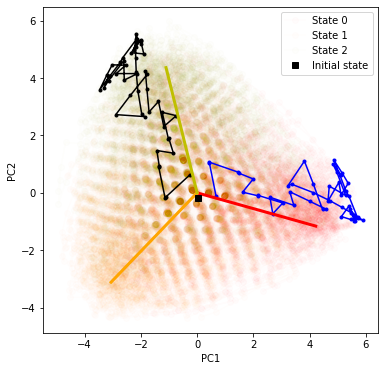

In [ ]:
# Here, we visualize the hidden states of the RNN, projected into a
# low-dimensional 2D state space.

plt.figure(figsize=(6, 6))

pc1 = 0
pc2 = 1

# state_labels = ['Positive examples', 'Negative examples']
state_labels = ['State {}'.format(i) for i in range(len(toy_params['sentiments']))]
state_colors = ['r', 'orange', 'y', 'g', 'b', 'm']
for i in range(len(toy_params['sentiments'])):
  pca_states = pca_full.transform(np.vstack(states[i])).T
  plt.plot(pca_states[pc1], pca_states[pc2], c = state_colors[i], marker='o', alpha=0.01, label=state_labels[i])

plt.plot(pca_path[:,pc1], pca_path[:,pc2], c='k', marker='.')
plt.plot(rot_pca_path[:,pc1], rot_pca_path[:,pc2], c='b', marker='.')

# Plots readout direction
for i in range(len(readout)):
  ro_dir = np.matmul(comp, readout[i])
  x_ro = [0, ro_dir[pc1]]
  y_ro = [0, ro_dir[pc2]]
  plt.plot(x_ro, y_ro, state_colors[i], linewidth = 3)

pca_h0 = pca.transform(np.atleast_2d(h0)).T
plt.plot(pca_h0[pc1], pca_h0[pc2], 'ks', label='Initial state')

plt.xlabel('PC'+str(pc1+1))
plt.ylabel('PC'+str(pc2+1))
# plt.xlim(-5, 5)
# plt.ylim(-5, 5)

plt.legend()

#### Network Flow

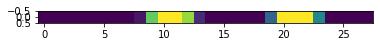

Path label: 0


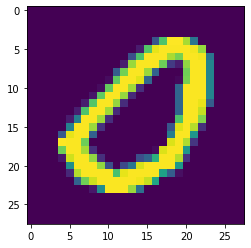

Path label: 1


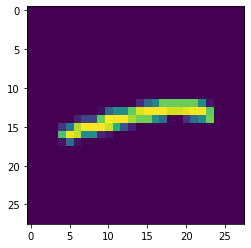

Path label: 0


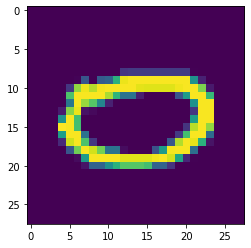

In [212]:
plt.imshow(test_data_input_flat[53, 11:12])
plt.show()

path_idxs = [53, 452, 259]
for path_idx in path_idxs:
  print('Path label:', smnist_params['mnist_classes'][np.argmax(hs_data['labels'][path_idx][27])])
  plt.imshow(np.asarray(test_data_input_flat[path_idx]))
  plt.show()

In [281]:
# Shows flow of network at various locations in hidden-state space
pc_dims = 5

# flow_points_raw = fixed_points
flow_points_raw = pts
# word_tensor = jnp.zeros(rnn_specs['input_size'])
word_tensor = mean_input

# word_tensor = test_data_input_flat[53, 11]
# word_tensor = test_data_input_flat[53, 12]
# word_tensor = test_data_input_flat[452, 13]

# word_tensor = np.asarray([wordToTensor('not', toy_params['words'])[0], wordToTensor('very0', toy_params['words'])[0]])

# Filters out non-unique points
unique_tol = 0.25
do_print = True
points_unique, unique_kidxs = keep_unique_fixed_points(flow_points_raw, unique_tol, do_print)
steps = 1

points_reduced = points_unique #[::18]
points_final_pca = np.zeros((len(points_reduced), pc_dims))
# print(points_reduced.shape)
points_init_pca = pca.transform(np.vstack(points_reduced))
for pt_idx in range(len(points_reduced)):
  # print(points_reduced[pt_idx].shape)
  # points_init_pca[pt_idx] = np.matmul(comp, points_reduced[pt_idx])
  ref_point = points_reduced[pt_idx]
  for step in range(steps):
    def_state = cell.apply(rnn_params, word_tensor, ref_point)
    ref_point = def_state
  points_final_pca[pt_idx] = pca.transform(np.atleast_2d(def_state))[0]
  # points_final_pca[pt_idx] = np.matmul(comp, def_state)

print(points_init_pca.shape)
print(points_final_pca.shape)

    Kept 2570/7000 unique fixed points with uniqueness tolerance 0.250000.
(2570, 5)
(2570, 5)


Path label: [1. 0. 0.]
Path label: [0. 0. 1.]
Path label: [0. 1. 0.]


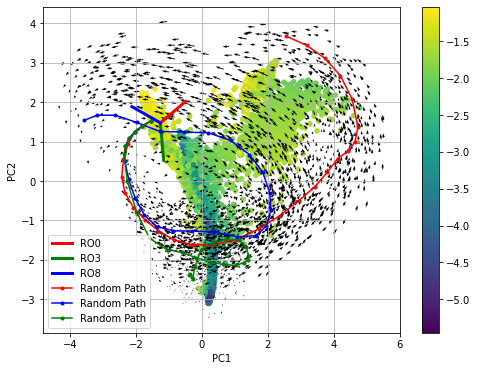

In [282]:
plt.figure(figsize=(8, 6))

pc1 = 0
pc2 = 1

pca_fps = pca.transform(np.vstack(fixed_points)).T
plt.scatter(pca_fps[pc1], pca_fps[pc2], s=20, c=np.log10(fp_losses))
plt.grid()

plt.colorbar()

pca_ro = pca.transform(readout)
pca_zero = pca.transform(np.atleast_2d(np.zeros((128,)))).T
for i in range(len(readout)):
  # ro_dir = pca.transform(readout[i]).T #np.matmul(comp, readout[i])
  x_ro = [pca_zero[pc1], pca_ro[i][pc1]]
  y_ro = [pca_zero[pc2], pca_ro[i][pc2]]
  plt.plot(x_ro, y_ro, state_colors[i], linewidth = 3, label='RO'+str(smnist_params['mnist_classes'][i]))

plt.quiver(points_init_pca[:,pc1], points_init_pca[:,pc2], 
           points_final_pca[:,pc1]-points_init_pca[:,pc1], points_final_pca[:,pc2]-points_init_pca[:,pc2])

# pca_h0 = pca.transform(np.atleast_2d(h0)).T
# plt.plot(pca_h0[pc1], pca_h0[pc2], 'ks', label='Initial state')
for path_idx in path_idxs:
  path_pca = pca.transform(hs[path_idx]).T #np.matmul(comp, hs[path_idx].T)
  plt.plot(path_pca[pc1], path_pca[pc2], state_colors[np.argmax(hs_data['labels'][path_idx][27])], marker='.', label='Random Path')
  print('Path label:', hs_data['labels'][path_idx][27])

plt.xlabel('PC'+str(pc1+1))
plt.ylabel('PC'+str(pc2+1))
plt.legend()

plot_coordinate = None
if plot_coordinate != None:
  plt.xlim(-plot_coordinate, plot_coordinate)
  plt.ylim(-plot_coordinate, plot_coordinate)

# Training Analysis

In [ ]:
def pca_analysis(opt_state, toy_params, rnn_specs):
  cell = build_cell(rnn_specs)

  n_trials = 1000 # Number of phrases to gather hidden states from
  rnn_params, readout_params = get_params(opt_state)

  syn_data_test = generate_data(n_trials, toy_params, rnn_specs['output_size'])

  hs = rnn_states(syn_data_test, rnn_params)
  pts = np.vstack(hs)[::2] # Gets every other state to eliminate states that are too close

  if rnn_specs['ro_bias']:
    wO, bO = readout_params
  else:
    wO = readout_params
  readout_vecs = wO.T

  # Finds percentage of variance explained by top pc_dims of PCA
  pca_full = PCA(n_components=rnn_specs['hidden_size'])
  _ = pca_full.fit_transform(pts)
  explained_var = pca_full.explained_variance_ratio_

  return explained_var, readout_vecs

In [ ]:
seed = 342343
print("Seed: %d" % seed)
prng_key = jax.random.PRNGKey(seed) # create a random key for jax for use on device.

########## Toy data parameters ##########
toy_params = {
  'phrase_length': 50,
  'loss_type': 'XE',
  'context_words' : True,
  'variable_length': False, # Takes max phrase length as phrase length
  'min_phrase_len': 10,
  'unordered_class': True, # Use an unordered class set
  'n_unordered': 3,
}

# toy_params['words'] = ['the', 'kinda1100', 'kinda0011', 'kinda1010', 'kinda0101']
toy_params['words'] = generateWordBank(toy_params)
# toy_params['sentiments'] = ['One', 'Two', 'Three', 'Four', 'Five']
# toy_params['words'].append('kinda01')
# toy_params['words'].append('kinda01')
# toy_params['words'].remove('kinda0')
# toy_params['words'].remove('kinda1')
# toy_params['words'].remove('very0')
# toy_params['words'].remove('very1')
# toy_params['words'].remove('very2')
# toy_params['words'].remove('very3')
# toy_params['words'].remove('very4')
# toy_params['words'].append('bad0')
# toy_params['words'].append('bad1')
# toy_params['sentiments'] = ['Red', 'Green', 'Blue']
# toy_params['sentiments'] = ['Bad', 'Neutral', 'Good']
if toy_params['unordered_class']:
  toy_params['sentiments'] = ['sent'+str(i) for i in range(toy_params['n_unordered'])]

########## RNN hyperparameters ##########
rnn_specs = {
  'cell_type': 'LSTM',                               # Supports 'GRU' or 'LSTM'
  'input_size': len(toy_params['words']),           # Number of inputs to the RNN
  'hidden_size': 128,                               # Number of units in the RNN
  'output_size': len(toy_params['sentiments']),     # Number of outputs in the RNN
  'ro_bias': False,                                 # Include a bias with the readout
  'ro_simplex_init': False,
}

########## Train hyperparameters ##########

train_params = {
  'max_grad_norm': 10.0,      # max gradient norm before clipping, clip to this value.
  'l2reg': 2e-5,           # amount of L2 regularization on the weights

  'init_lr': 0.1,                     # initial learning rate
  'decay_factor': 0.9997,             # decay the learning rate this much
  'adam_b1': 0.9,                     # Adam parameters (b1=0.9, b2=0.99, eps=1e-8 are defaults)
  'adam_b2': 0.99,
  'adam_eps': 1e-1,

  'batch_size': 128,                     # How many examples in each batch
  'num_batchs': 100,                    # Total number of batches to train on.
  'print_every': 100,                     # Print training informatino every so often

  'n_datasets': 1,                           # Number of new train sets to generate total (this is slow)
  'epochs': 1,                               # How many times to go through each train set completely
  'test_set_size': 200,

  'decay_fun': optimizers.exponential_decay(init_lr, decay_steps=1, decay_rate=decay_factor),
}

train_params['train_set_size'] = train_params['batch_size'] * train_params['num_batchs'] # Number of examples in train set

Seed: 342343


In [ ]:
num_checkpoints = 100

########## Run ##########

print('Total words:', len(toy_params['words']), 'Words:', toy_params['words'])
print('Total sentiments:', len(toy_params['sentiments']), 'Sentiments:', toy_params['sentiments'])

new_network = True
load_network = False
save_data = False

path = '/content/drive/My Drive/ml_research/fixedpoints_nlp/gru_2x2class_xe_noRO.pickle'
save_data = override_data(path, save_data)

if new_network:
  # Initialize the optimizer.  Please see jax/experimental/optimizers.py
  init_fun, apply_fun, mask_fun, loss_fun, accuracy_fun = build_rnn(rnn_specs)
  input_shape = (train_params['batch_size'], toy_params['phrase_length'], len(toy_params['words']))
  output_shape, initial_params = init_fun(prng_key, input_shape)

  opt = optimizers.adam(train_params['decay_fun'], train_params['adam_b1'], train_params['adam_b2'], train_params['adam_eps'])
  opt_state, step_fun = build_optimizer_step(opt, initial_params, loss_fun, gradient_clip=train_params['max_grad_norm'])
  
  init_opt, update_opt, get_params = opt

  train_params['train_losses'] = []
  train_params['global_step'] = 0
  train_params['total_steps'] = 0

elif load_network:
 
  initial_params = params_loaded_jax
  output_shape = (train_params['batch_size'], toy_params['phrase_length'], len(toy_params['sentiments']))

  opt = optimizers.adam(train_params['decay_fun'], train_params['adam_b1'], train_params['adam_b2'], train_params['adam_eps'])
  opt_state, step_fun = build_optimizer_step(opt, initial_params, loss_fun, gradient_clip=train_params['max_grad_norm'])

  init_opt, update_opt, get_params = opt

  train_params['train_losses'] = train_params['train_losses'] if 'train_losses' in train_params else []
  train_params['global_step'] = train_params['total_steps']

explained_var = np.zeros((num_checkpoints, rnn_specs['hidden_size']))
if rnn_specs['cell_type'] == 'Vanilla' or rnn_specs['cell_type'] == 'GRU' or rnn_specs['cell_type'] == 'UGRNN' :
  readout_cps = np.zeros((num_checkpoints, rnn_specs['output_size'], rnn_specs['hidden_size']))
elif rnn_specs['cell_type'] == 'LSTM':
  readout_cps = np.zeros((num_checkpoints, rnn_specs['output_size'], 2*rnn_specs['hidden_size']))
checkpoint_batches = np.zeros((num_checkpoints,))

for cp in range(num_checkpoints):
  # Calculates before train, so checkpoint 0 is initial data
  explained_var[cp], readout_cps[cp] = pca_analysis(opt_state, toy_params, rnn_specs)
  checkpoint_batches[cp] = train_params['global_step']

  # Generate synthetic data and run training on said data
  opt_state, train_params = train_on_synthetic_data(opt_state, train_params, toy_params, rnn_specs)

Total words: 9 Words: ['kinda0', 'very0', 'kinda1', 'very1', 'kinda2', 'very2', 'the', 'not', 'extremely']
Total sentiments: 3 Sentiments: ['sent0', 'sent1', 'sent2']
Sythentic data generated in: 0.35 sec.
Sythentic data generated in: 4.43 sec.
Sythentic data generated in: 0.07 sec.
Running batches 0 to 100
Step 100 in 5.93 sec, step size: 0.09707, test acc 0.3600, avg training loss 1.2738
Sythentic data generated in: 0.35 sec.
Sythentic data generated in: 4.48 sec.
Sythentic data generated in: 0.07 sec.
Running batches 100 to 200
Step 200 in 1.95 sec, step size: 0.09420, test acc 0.3400, avg training loss 1.0968
Sythentic data generated in: 0.35 sec.
Sythentic data generated in: 4.35 sec.
Sythentic data generated in: 0.07 sec.
Running batches 200 to 300
Step 300 in 1.96 sec, step size: 0.09142, test acc 0.3650, avg training loss 1.1008
Sythentic data generated in: 0.33 sec.
Sythentic data generated in: 4.38 sec.
Sythentic data generated in: 0.07 sec.
Running batches 300 to 400
Step 40

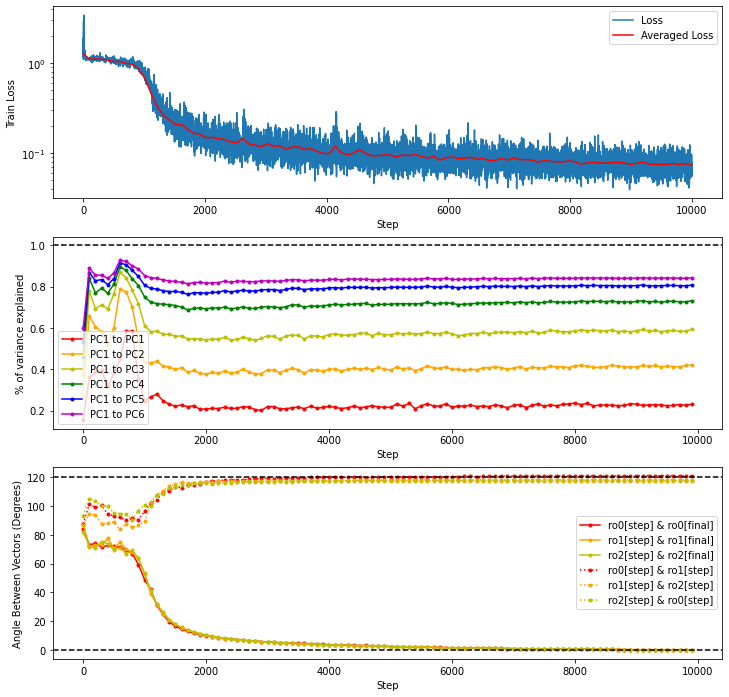

In [ ]:
pc_dims = 5
total_exvar = np.zeros((num_checkpoints, rnn_specs['hidden_size']-1))
ro_angles = np.zeros((num_checkpoints, rnn_specs['output_size']))
ro_rel_angles = np.zeros((num_checkpoints, rnn_specs['output_size']))
final_ro = readout_cps[num_checkpoints-1] # n_readouts x n_hidden

for cp in range(num_checkpoints):
  # print('Top', pc_dims, 'components:', np.sum(explained_var[cp][:pc_dims]), '(', explained_var[cp][:pc_dims],')')
  for i in range(rnn_specs['hidden_size']-1):
    total_exvar[cp][i] = np.sum(explained_var[cp][:i+1])
  for ro in range(rnn_specs['output_size']):
    dot_val = np.dot(readout_cps[cp][ro], final_ro[ro])/(np.linalg.norm(readout_cps[cp][ro])*np.linalg.norm(final_ro[ro]))
    ro_angles[cp][ro] = 180/np.pi * np.arccos(dot_val)
  for ro in range(rnn_specs['output_size']):
    ro2 = (ro+1) % rnn_specs['output_size']
    dot_val = np.dot(readout_cps[cp][ro],readout_cps[cp][ro2])/(np.linalg.norm(readout_cps[cp][ro])*np.linalg.norm(readout_cps[cp][ro2]))
    ro_rel_angles[cp][ro] = 180/np.pi * np.arccos(dot_val)
  
plt.figure(figsize=(12,12))
# ax1 = plt.subplot('131')
# ax1.plot(total_exvar[0][:20], 'k-', marker='.', label='Initial State')
# ax1.plot(total_exvar[num_checkpoints-1][:20], 'b-', marker='.', label='Final State')
# ax1.set_xlabel('PC Dimension')
# ax1.set_ylabel('% of variance explained')
# ax1.axhline(1.0, c='k', linestyle='--')
# ax1.legend()

ax1 = plt.subplot('311')
train_losses = train_params['train_losses']
n_avg = 100
avg_loss = [1/n_avg * np.sum(train_losses[i*n_avg:(i+1)*n_avg]) for i in range(int(len(train_losses)/n_avg))]
ax1.semilogy(np.linspace(1,len(train_losses),len(train_losses)), train_losses, label='Loss')
ax1.semilogy(np.linspace(1,len(train_losses),int(len(train_losses)/n_avg)), avg_loss,'r', label='Averaged Loss')
ax1.set_xlabel('Step')
ax1.set_ylabel('Train Loss')
ax1.legend()

ax2 = plt.subplot('312')
n_pc_dims = 6
plot_colors = ['r', 'orange', 'y', 'g', 'b', 'm']
for i in range(n_pc_dims):
  ax2.plot(checkpoint_batches, total_exvar[:, i], c = plot_colors[i], marker='.', label='PC1 to PC{}'.format(i+1))
ax2.set_xlabel('Step')
ax2.set_ylabel('% of variance explained')
ax2.axhline(1.0, c='k', linestyle='--')
ax2.legend()

ax3 = plt.subplot('313')
for i in range(rnn_specs['output_size']):
  ax3.plot(checkpoint_batches, ro_angles[:, i], c=plot_colors[i], marker='.', label='ro{}[step] & ro{}[final]'.format(i,i))
for i in range(rnn_specs['output_size']):
  ax3.plot(checkpoint_batches, ro_rel_angles[:, i], c=plot_colors[i], marker='.', linestyle='dotted',
           label='ro{}[step] & ro{}[step]'.format(i,(i+1) % rnn_specs['output_size']))

ax3.set_xlabel('Step')
ax3.set_ylabel('Angle Between Vectors (Degrees)')
ax3.axhline(0.0, c='k', linestyle='--')
ax3.axhline(180/np.pi * np.arccos(-1/(rnn_specs['output_size']-1)), c='k', linestyle='--')
ax3.legend()

### Set Readouts Tests

In [ ]:
def simplex_readouts(rand_seed, dimensions):
  """ Returns readouts which are the vertices of an n-simplex"""
  print('Initializing readouts as simplex dimensions.')
  if len(dimensions) > 2:
    raise NotImplementedError('Only current takes two dimensions, input and output')
  n_readouts = dimensions[1]
  hidden_dim = dimensions[0]
  center = np.zeros((hidden_dim,))
  for i in range(n_readouts):
    center[i] = 1/n_readouts
  readouts = np.zeros((hidden_dim, n_readouts))
  for i in range(n_readouts):
    readouts[i][i] = 1
    readouts[:,i] = center - readouts[:,i]

  return readouts

readouts = simplex_readouts(5, (128, 3)).T
print(readouts.shape)
print(readouts[0][:5])
print(readouts[1][:5])
print(readouts[2][:5])
180/np.pi*np.arccos(np.dot(readouts[0], readouts[1])/(np.linalg.norm(readouts[0]) * np.linalg.norm(readouts[1])))

Initializing readouts as simplex dimensions.
(3, 128)
[-0.66666667  0.33333333  0.33333333  0.          0.        ]
[ 0.33333333 -0.66666667  0.33333333  0.          0.        ]
[ 0.33333333  0.33333333 -0.66666667  0.          0.        ]


120.00000000000001

# Bag of Words Tests

In [107]:
def SequenceSum():
    def init_fun(_, input_shape):
        return (input_shape[0], input_shape[2]), ()
    def apply_fun(_, inputs, **kwargs):
        return jnp.sum(inputs, axis=1)
    return init_fun, apply_fun

# Loss
def xent(params, batch):
    logits = apply_fun(params, batch['inputs'])
    targets = batch['labels'][:,smnist_params['n_len']-1]
    data_loss = -jnp.mean(jnp.sum(targets * logits, axis=1))
    reg_loss = l2_pen * renn.norm(params)
    return data_loss + reg_loss

# Accuracy
@jax.jit
def accuracy(params, batch):
    logits = apply_fun(params, batch['inputs'])
    predictions = jnp.argmax(logits, axis=1)
    target_labels = jnp.argmax(batch['labels'][:,smnist_params['n_len']-1], axis=1)
    return jnp.mean(predictions == target_labels)

@jax.jit
def bow_step(k, opt_state, batch):
    params = get_params(opt_state)
    loss, gradients = f_df(params, batch)
    new_state = update_opt(k, gradients, opt_state)
    return new_state, loss

def test_acc(params, batch):
    return jnp.array([accuracy(params, batch)])

def full_test_accuracy_bow(test_jax, state):
  num_batchs = test_jax['inputs'].shape[0]
  test_acc_batch = np.zeros((num_batchs, ))

  for batch in range(num_batchs):
      batch_data = {
        'inputs': test_jax['inputs'][batch], # Phrase tensors: batch x phrase_len x in_dim
        'labels': test_jax['labels'][batch], # Sentiment tensors: batch x phrase_len x out_dim
        'index': test_jax['index'][batch], # Target mask: list of integers up to phrase_len
      }

      test_acc_batch[batch] = np.mean(test_acc(get_params(state), batch_data))

  return np.mean(test_acc_batch)

In [261]:
train_params = {
  'max_grad_norm': 10.0,      # max gradient norm before clipping, clip to this value.

  'batch_size': 128,         # Total number of batches to train on.
  'print_every': 100,                     # Print training informatino every so often

  'epochs': 50,                               # How many times to go through each train set completely
  'num_batchs': train_jax['inputs'].shape[0]
}

input_shape = (train_params['batch_size'],  smnist_params['n_len'], smnist_params['n_inputs'])
l2_pen = 1e-3

# Linear model
init_fun, apply_fun = stax.serial(
    SequenceSum(),
    stax.Dense(len(smnist_params['mnist_classes'])),
    stax.LogSoftmax,
)

# Initialize
key = jax.random.PRNGKey(0)
output_shape, initial_params = init_fun(key, input_shape)

f_df = jax.value_and_grad(xent)

# Train
learning_rate = optimizers.exponential_decay(2e-3, 1000, 0.8)
init_opt, update_opt, get_params = optimizers.adam(learning_rate)

state = init_opt(initial_params)
losses = []
global_step = 0
total_steps = 0
batch_size = train_params['batch_size']
num_batchs = train_params['num_batchs']

val_data = {
      'inputs': test_jax['inputs'][0], # Phrase tensors: batch x phrase_len x in_dim
      'labels': test_jax['labels'][0], # Sentiment tensors: batch x phrase_len x out_dim
      'index': test_jax['index'][0], # Target mask: list of integers up to phrase_len
    }

for epoch in range(train_params['epochs']):
  # Shuffles training data after first epoch
  if epoch > 0:
    train_jax = shuffle_data_smnist(train_jax)

  # print('Running batches {} to {}'.format(global_step, global_step+num_batchs))
  start_time = time.time()  
  avg_loss = 0 
  for step in range(total_steps, total_steps+num_batchs):
    batch = step - total_steps 
    batch_data = {
      'inputs': train_jax['inputs'][batch], # Phrase tensors: batch x phrase_len x in_dim
      'labels': train_jax['labels'][batch], # Sentiment tensors: batch x phrase_len x out_dim
      'index': train_jax['index'][batch], # Target mask: list of integers up to phrase_len
    }
    
    state, loss = bow_step(global_step, state, batch_data)
    losses.append(loss)
    avg_loss += loss
    global_step += 1

    if (global_step+1) % train_params['print_every'] == 0:
      acc = np.mean(test_acc(get_params(state), val_data))
      batch_time = time.time() - start_time
      step_size = learning_rate(global_step)
      s = "Step {} in {:0.2f} sec, step size: {:0.5f}, test acc {:0.4f}, avg training loss {:0.4f}"
      print(s.format(global_step+1, batch_time, step_size, acc, avg_loss/train_params['print_every']))
      start_time = time.time()
      avg_loss = 0

full_test_accuracy_bow(test_jax, state)

Step 100 in 1.69 sec, step size: 0.00196, test acc 0.6484, avg training loss 2.3511
Step 200 in 0.06 sec, step size: 0.00191, test acc 0.7188, avg training loss 0.0938
Step 300 in 0.61 sec, step size: 0.00187, test acc 0.7578, avg training loss 0.8450
Step 400 in 0.14 sec, step size: 0.00183, test acc 0.7578, avg training loss 0.1600
Step 500 in 0.63 sec, step size: 0.00179, test acc 0.7578, avg training loss 0.7412
Step 600 in 0.20 sec, step size: 0.00175, test acc 0.7734, avg training loss 0.2186
Step 700 in 0.61 sec, step size: 0.00171, test acc 0.7734, avg training loss 0.6877
Step 800 in 0.28 sec, step size: 0.00167, test acc 0.7734, avg training loss 0.2823
Step 900 in 0.61 sec, step size: 0.00164, test acc 0.7656, avg training loss 0.6534
Step 1000 in 0.32 sec, step size: 0.00160, test acc 0.7734, avg training loss 0.3428
Step 1100 in 0.61 sec, step size: 0.00157, test acc 0.8203, avg training loss 0.6301
Step 1200 in 0.39 sec, step size: 0.00153, test acc 0.8125, avg training l